In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.stats as ss
import pickle
import sys
sys.path.append('synthetic_data/')
import extended_model as em
from itertools import combinations

# Figure S2

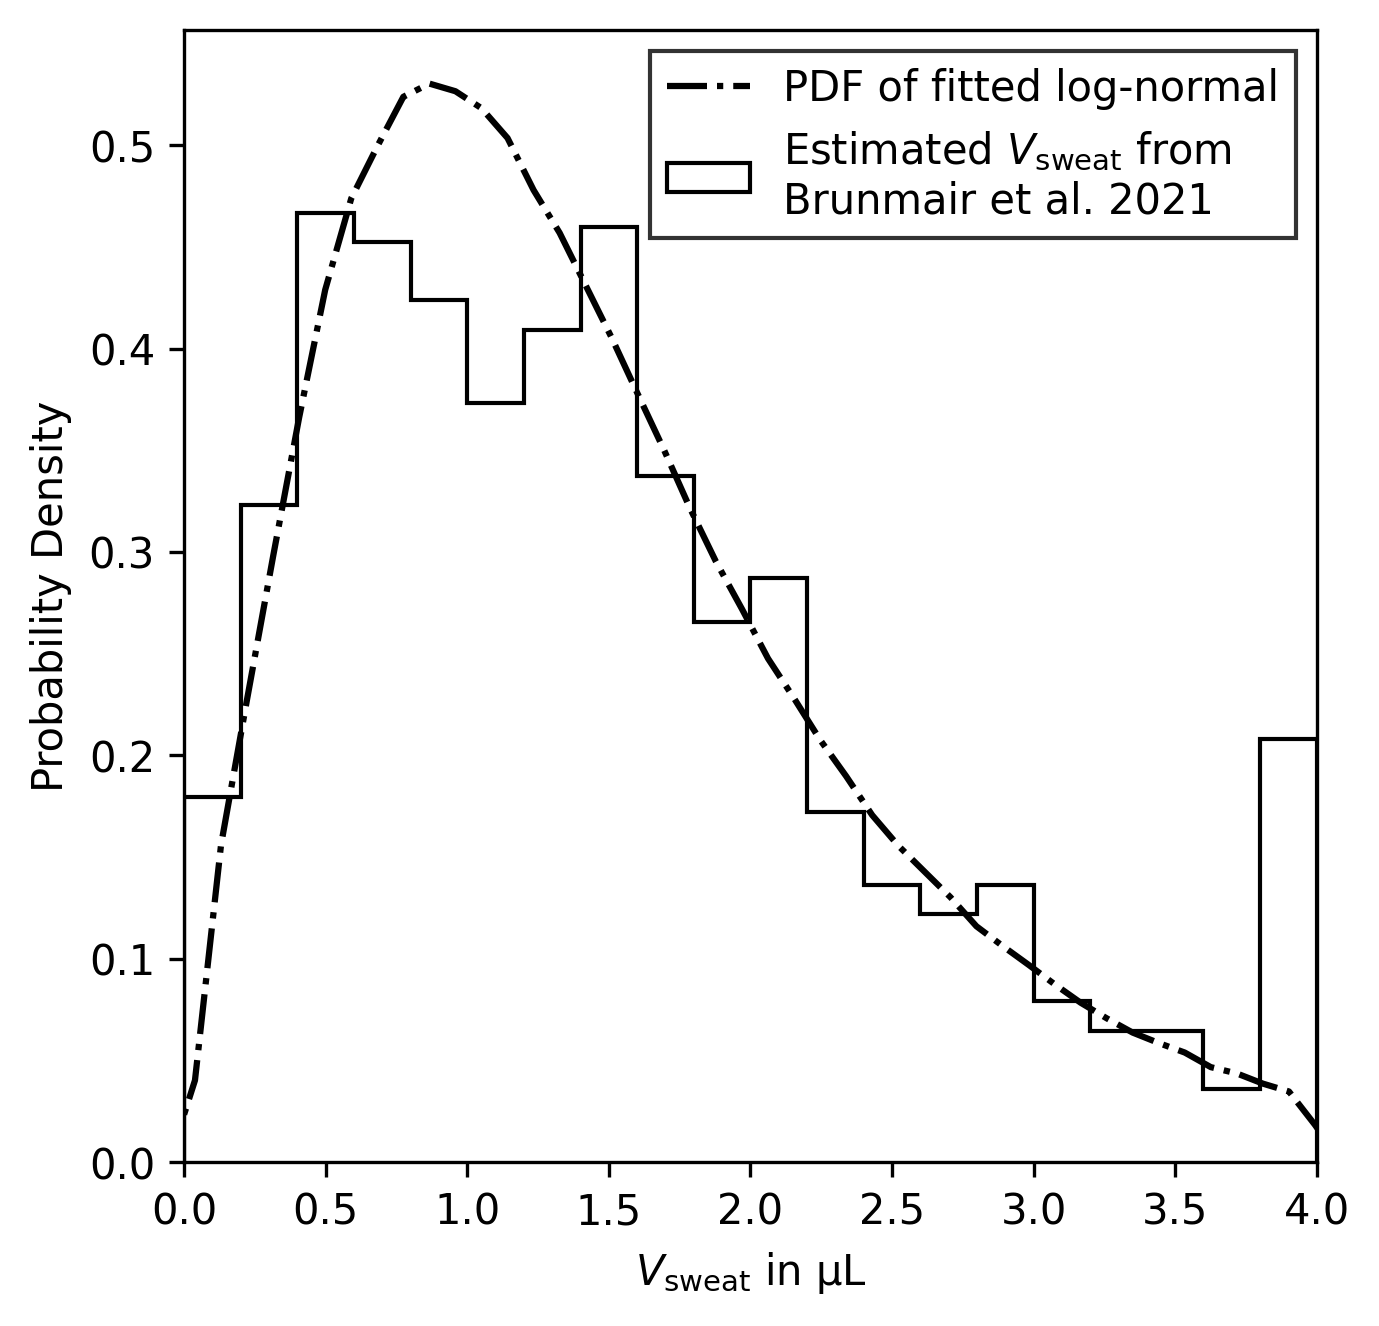

In [2]:
df = pd.read_csv('real_data/raw_data/imputed_untargeted.csv',index_col=0)

# fit a lognormal distribution through the data
p = ss.lognorm.fit(df['sv']) # shape, loc, scale
plt.figure(dpi=300,figsize=(5,5))
plt.subplot(111,box_aspect=1)

# truncated PDF
sample = ss.lognorm.rvs(*p,size=10**6)
sample = sample[(sample >= .05) & (sample <= 4)]
count, bins = np.histogram(sample,range=(-.1,4.5),bins=50,density=True)
plt.plot((bins[1:]+bins[:-1])/2,count,'k-.',label=r'PDF of fitted log-normal')

plt.hist(df['sv'],range=(0,4),bins=20,histtype='step',density=True,color='k',label=r'Estimated $V_{\rm sweat}$ from'+'\nBrunmair et al. 2021')
plt.xlim(0,4)
plt.legend(edgecolor='k',fancybox=False,loc='upper right')
plt.ylabel('Probability Density')
plt.xlabel(r'$V_{\rm sweat}$ in µL')
plt.show()

# Figure S5

In [3]:
# normalize by the estimated sweat volume from Brunmair et al. 2021
norm = df.copy()
norm.iloc[:,4:] = df.iloc[:,4:]/df.loc[:,'sv'].values[:,None]
# calculate mean and SD from every donor - metabolite combination
list_mean = []
list_std  = []
for donor in norm['donor'].unique():
    for metabolite in norm.columns[9:]:
        tmp = norm.loc[norm['donor']==donor,metabolite].values
        list_mean.append(np.mean(tmp))
        list_std.append(np.std(tmp))

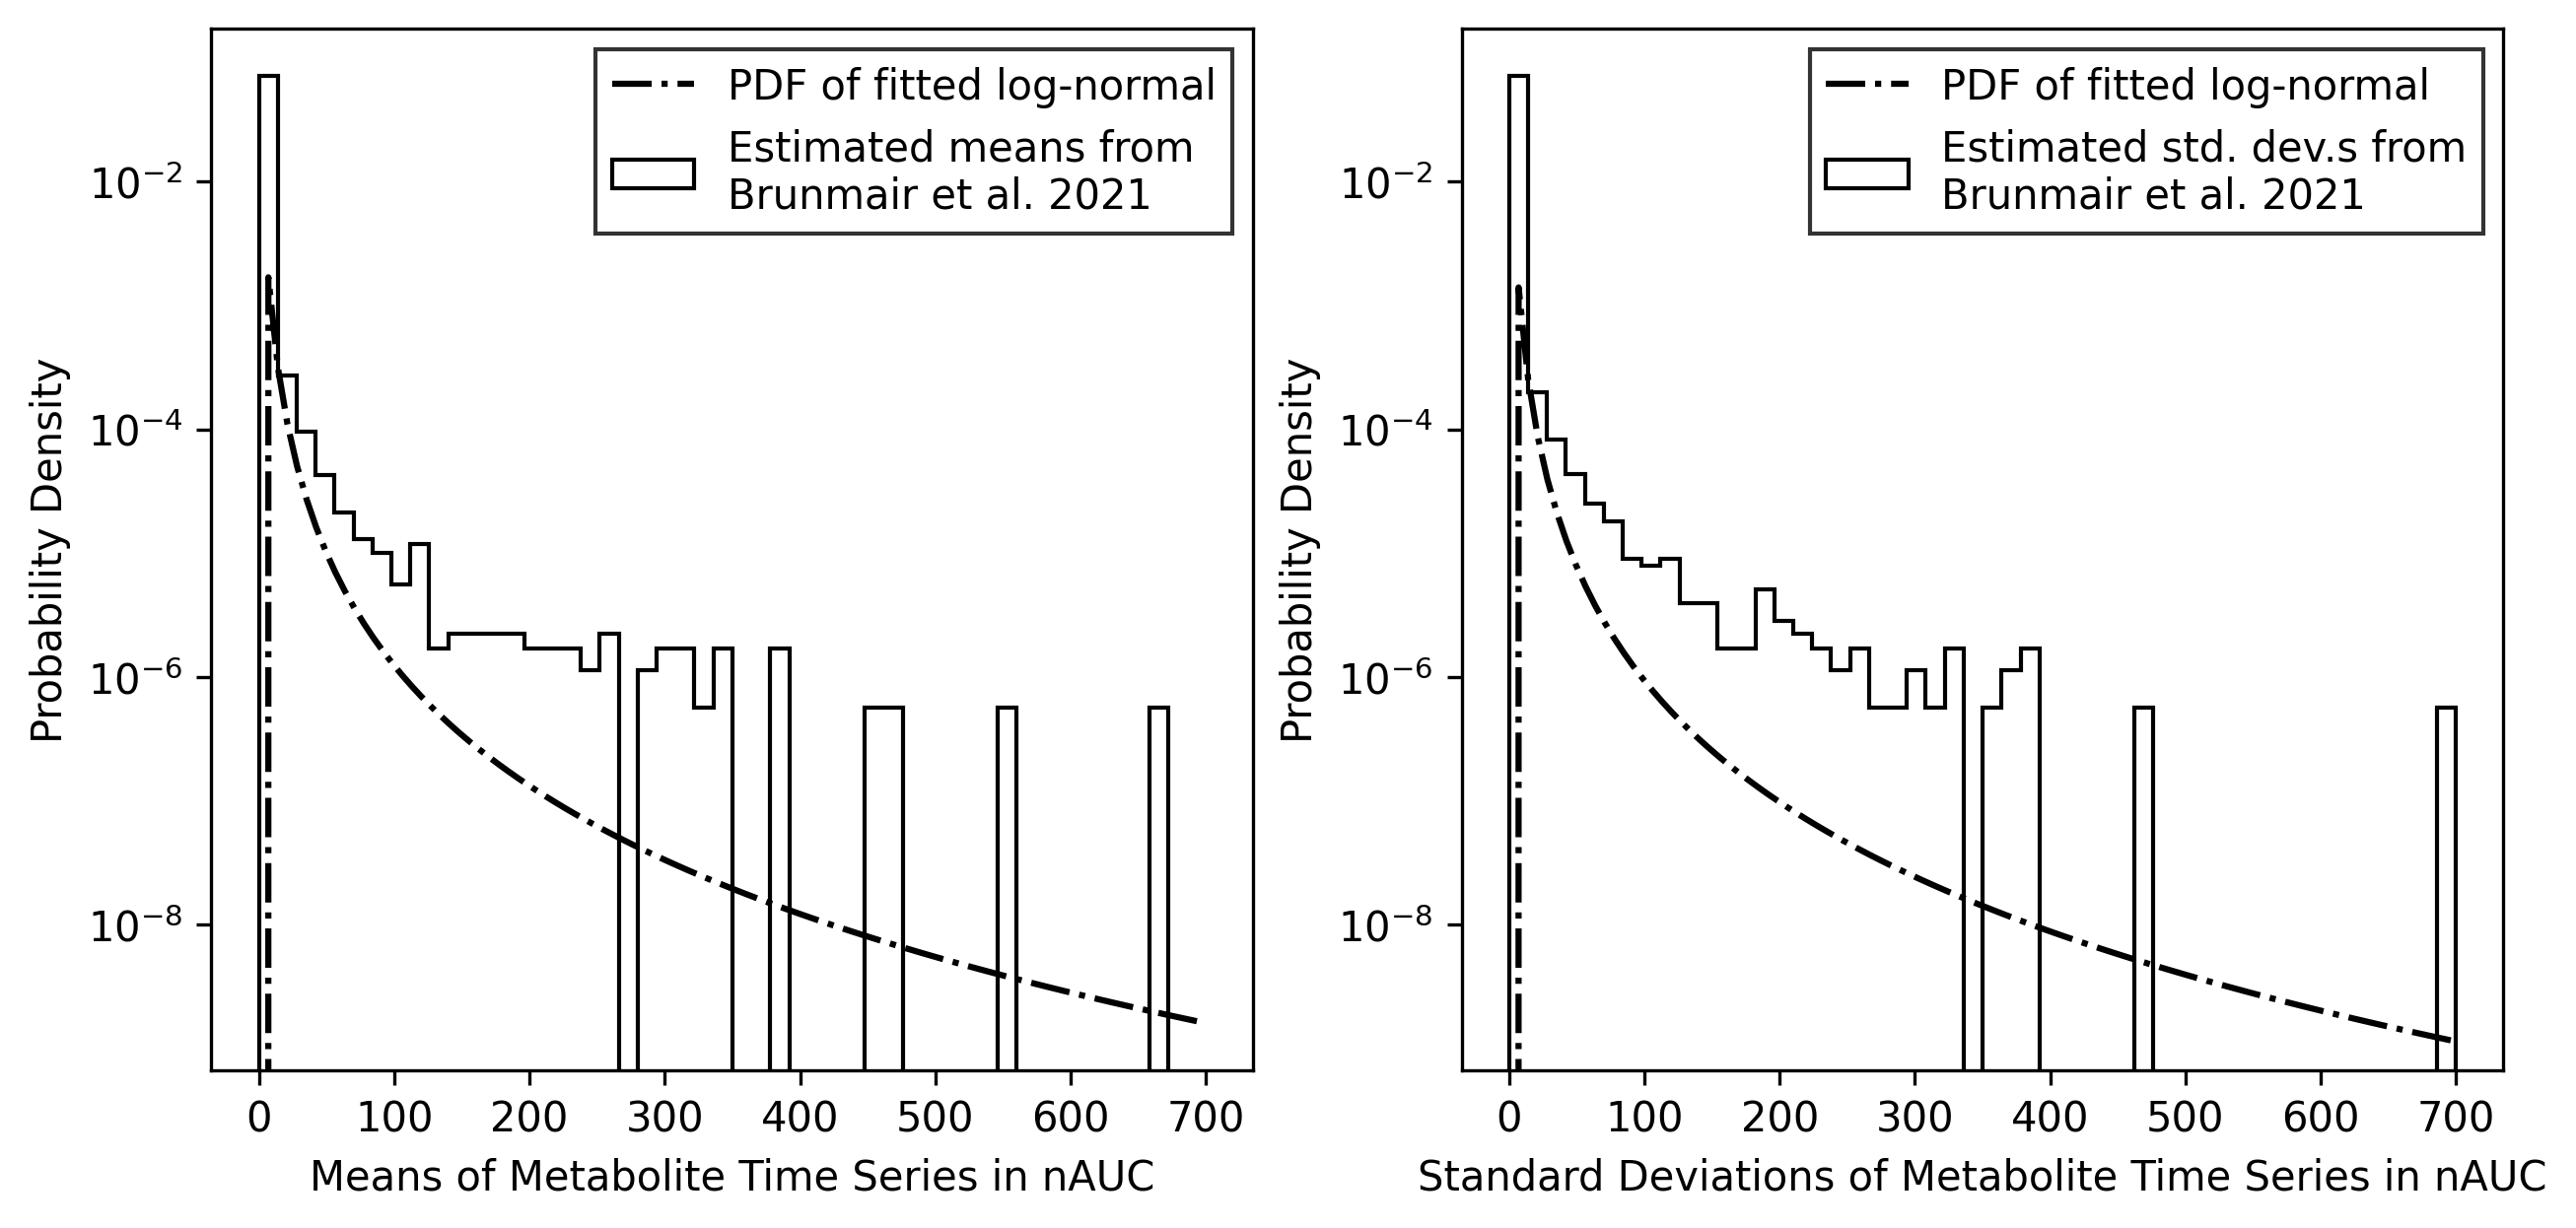

In [4]:
plt.figure(dpi=300,figsize=(10,5))

## SUBPLOT 1
## distribution of means
ax = plt.subplot(121,box_aspect=1)
p = ss.lognorm.fit(list_mean) # shape, loc, scale
# fitted PDF
max_ = 700
ls = np.linspace(0,max_,100)
plt.plot(ls,ss.lognorm.pdf(ls,*p),'k-.',label='PDF of fitted log-normal')
plt.hist(list_mean,histtype='step',range=(0,max_),density=True,bins=50,color='k',label='Estimated means from\nBrunmair et al. 2021')
plt.yscale('log')
plt.ylabel('Probability Density')
plt.xlabel('Means of Metabolite Time Series in nAUC')
plt.legend(edgecolor='k',fancybox=False,loc='upper right')

## SUBPLOT 2
## distribution of SDs
plt.subplot(122,box_aspect=1,sharex=ax,sharey=ax)
p = ss.lognorm.fit(list_std) # shape, loc, scale
# fitted PDF
ls = np.linspace(0,max_,100)
plt.plot(ls,ss.lognorm.pdf(ls,*p),'k-.',label='PDF of fitted log-normal')
# measured data
plt.hist(list_std,histtype='step',range=(0,max_),density=True,bins=50,color='k',label='Estimated std. dev.s from\nBrunmair et al. 2021')
plt.yscale('log')
plt.ylabel('Probability Density')
plt.xlabel('Standard Deviations of Metabolite Time Series in nAUC')
plt.legend(edgecolor='k',fancybox=False,loc='upper right')
plt.show()

# Figure S1

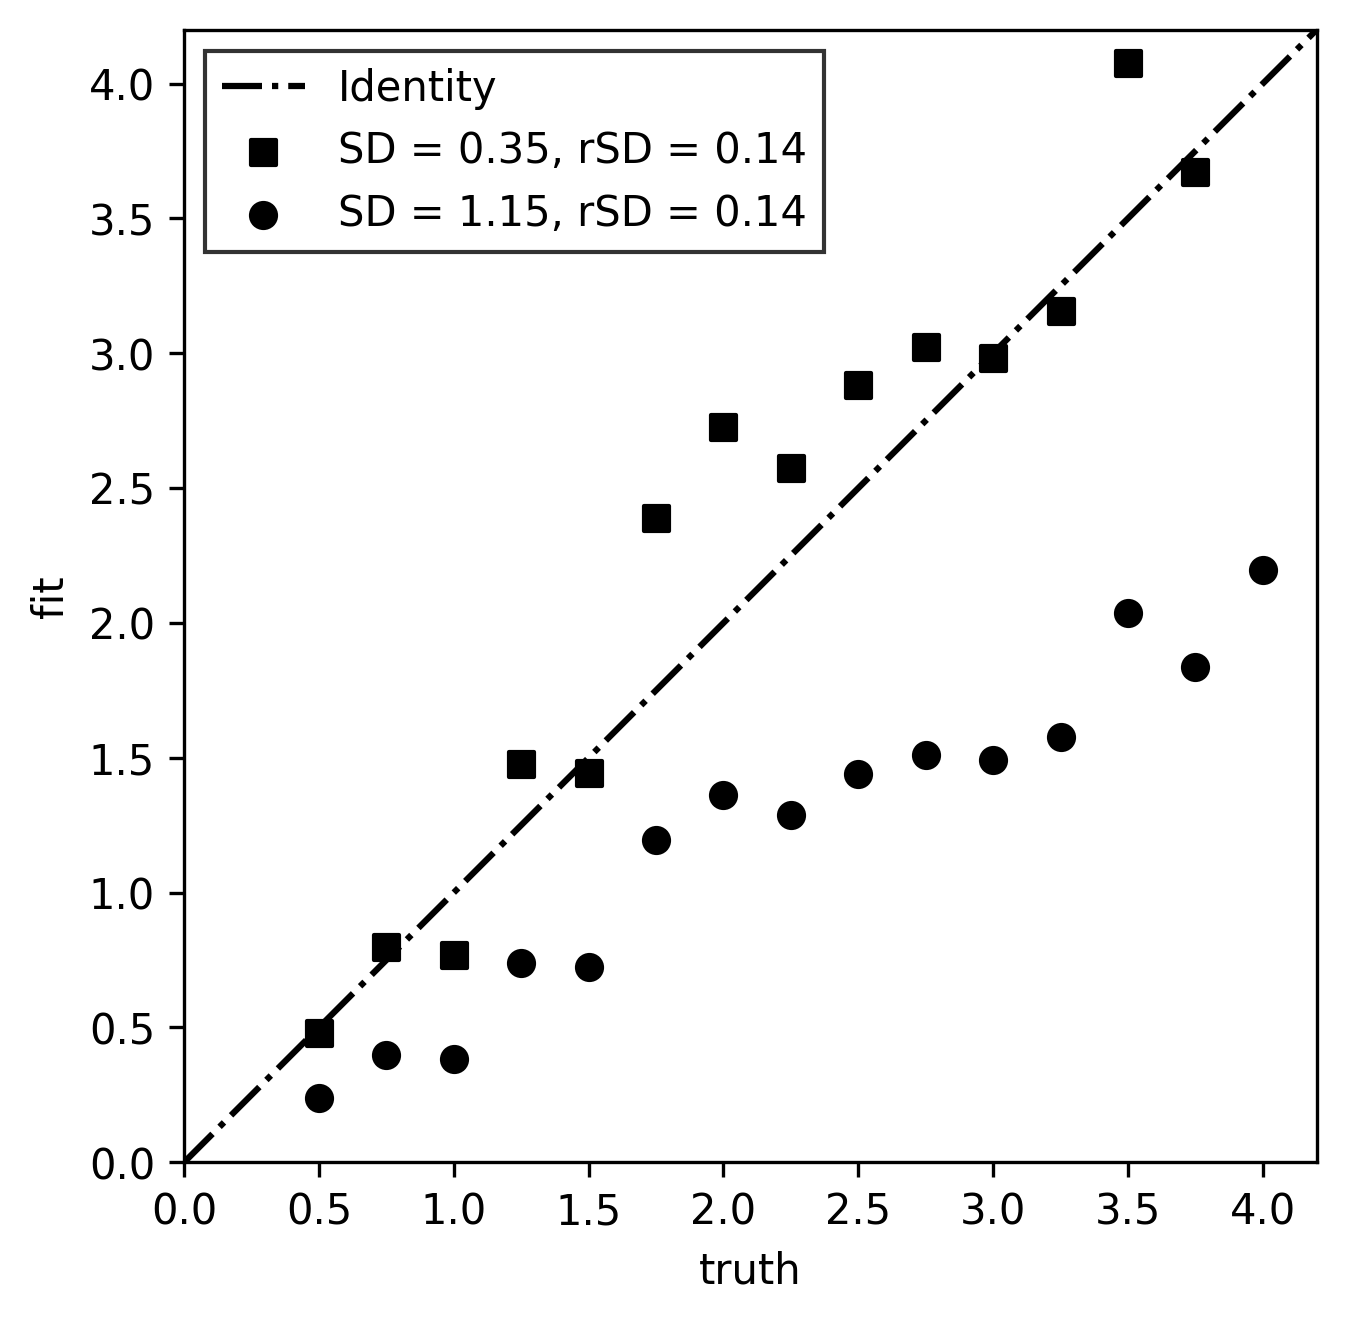

In [5]:
def SD(true,fit):
    return np.sqrt(np.sum((true-fit)**2)/len(true))

def ratio_SD(true,fit):
    y = fit/true
    return np.std(y/np.mean(y))

true = np.linspace(0.5,4,15)
e = np.random.normal(1,.2,15)
fit1 = true*e
fit2 = true*e*.5

plt.figure(dpi=300,figsize=(5,5))
ax = plt.subplot(111,box_aspect=1)

plt.scatter(true,fit1,label='SD = {:.2f}, rSD = {:.2f}'.format(SD(true,fit1),ratio_SD(true,fit1)),color='k',marker='s')
plt.scatter(true,fit2,label='SD = {:.2f}, rSD = {:.2f}'.format(SD(true,fit2),ratio_SD(true,fit2)),color='k',marker='o')
plt.plot((0,4.2),(0,4.2),'k-.',label='Identity')

plt.legend(edgecolor='k',fancybox=False,loc='upper left')
plt.xlim(0,4.2)
plt.ylim(0,4.2)
plt.xlabel('truth')
plt.ylabel('fit')
plt.show()

# Figure 6

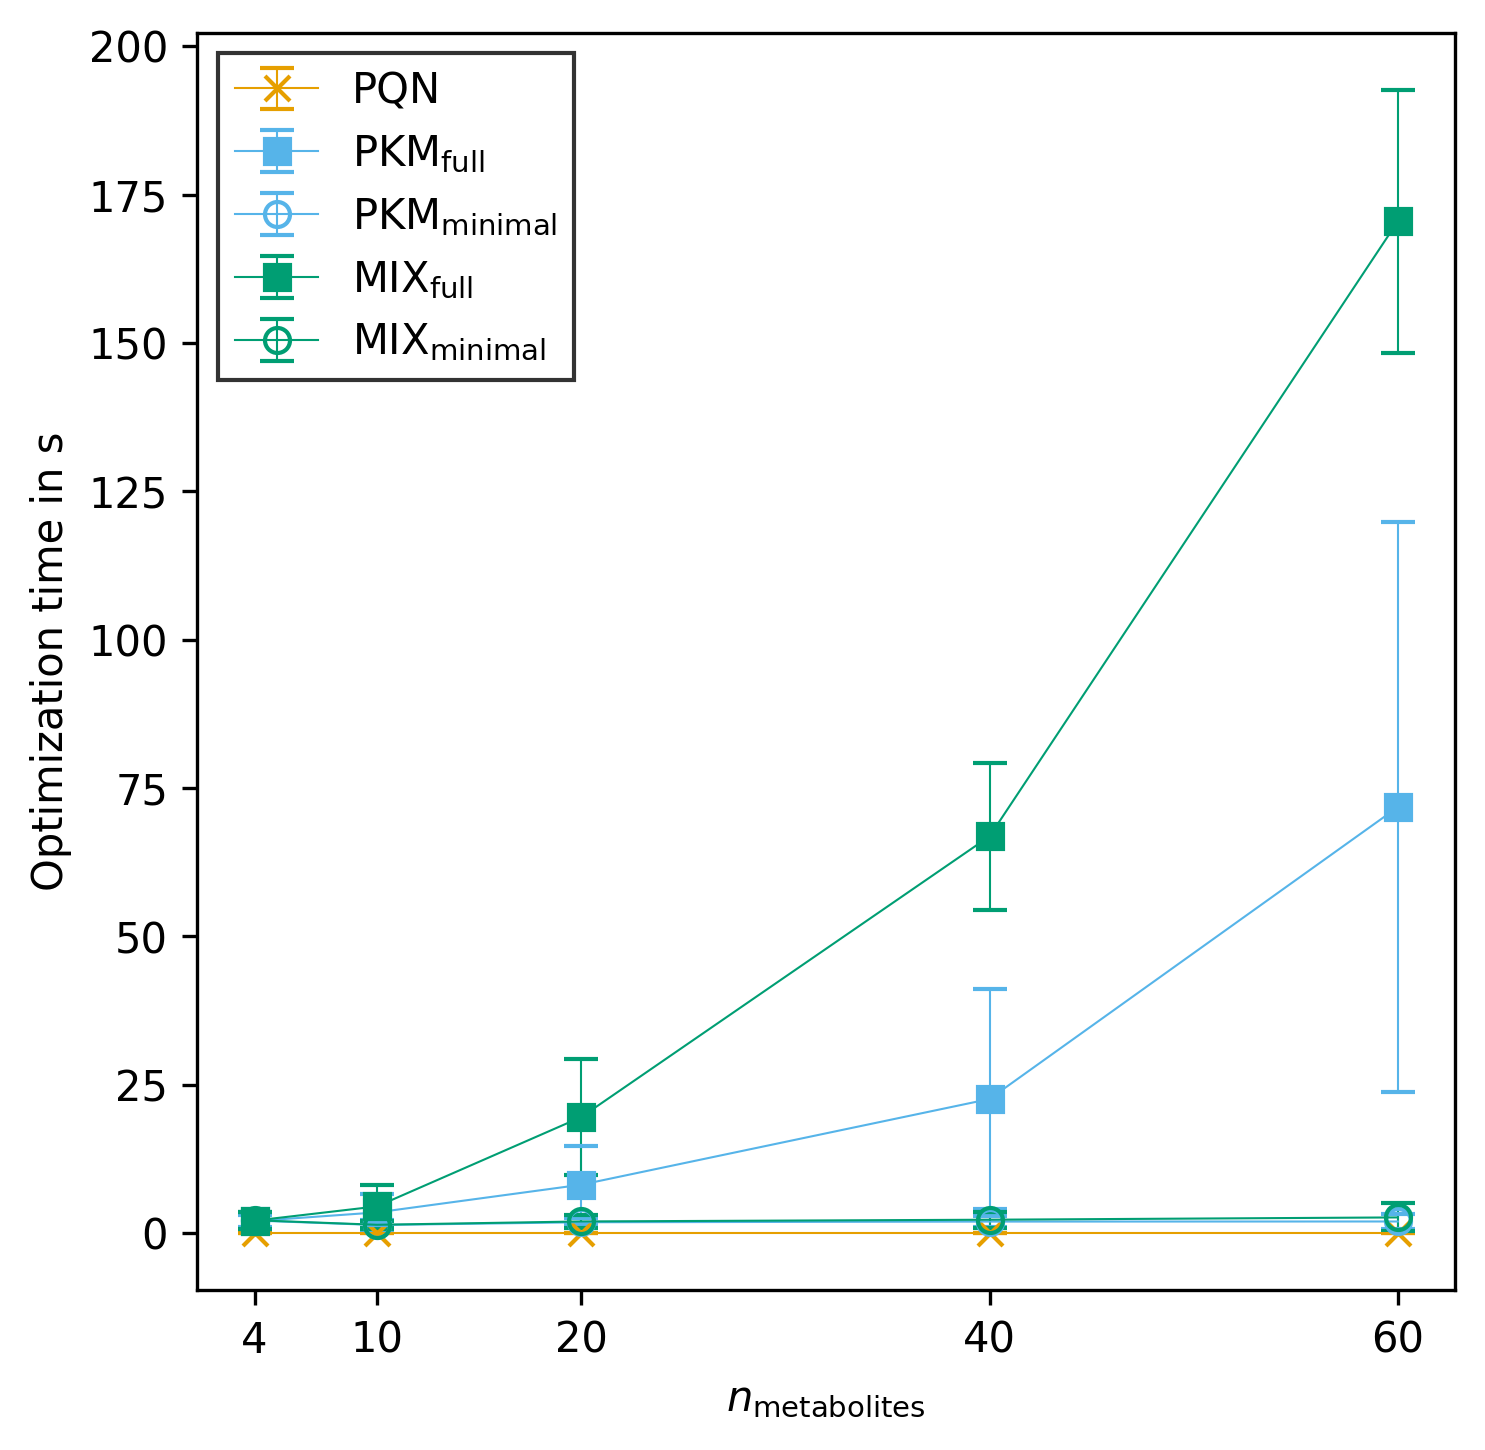

In [6]:
# load data
error_sigma   = .2
path          = 'v3' # you can also chose other simulations: v1, v2
base          = 'synthetic_data/simulation_results'
n_metabolites_list = np.array([4,10,20,40,60])
markers = ['x','s','o','s','o']
colors  = ['b','r','r','y','y']
colors  = ['#E69F00','#56B4E9','#56B4E9','#009E73','#009E73']
fcolors  = ['#E69F00','#56B4E9','none','#009E73','none']
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']
labels  = ['PQN',r'PKM$_{\rmfull}$',r'PKM$_{\rmminimal}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']

total_times = []
total_stds  = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp_times = []
    tmp_stds  = []
    for method in methods:
        tmp_times.append(np.mean(results_time[method]))
        tmp_stds.append(np.std(results_time[method]))
    total_times.append(tmp_times)
    total_stds.append(tmp_stds)
total_times = np.array(total_times)
total_stds  = np.array(total_stds)

# write out dataframes for means and stds 
time_results = pd.DataFrame(index=methods,columns=[f'{i} mean ' for i in n_metabolites_list]+[f'{i} stds ' for i in n_metabolites_list])
time_results.iloc[:,:len(n_metabolites_list)] = total_times.T
time_results.iloc[:,len(n_metabolites_list):] = total_stds.T

# plot figure
plt.figure(dpi=300,figsize=(5,5))
ax = plt.subplot(111,box_aspect=1)

for nr, label in enumerate(methods):
    plt.errorbar(n_metabolites_list,total_times[:,nr],yerr=total_stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=4,label=labels[nr],zorder=0,mfc=fcolors[nr])
plt.xticks(n_metabolites_list)
plt.xlabel(r'$n_{\rm metabolites}$')
plt.ylabel('Optimization time in s')

######## Concluding Commands
plt.legend(edgecolor='k',fancybox=False) # loc=(1.1,0),
plt.tight_layout()
plt.show()

# Figure 2

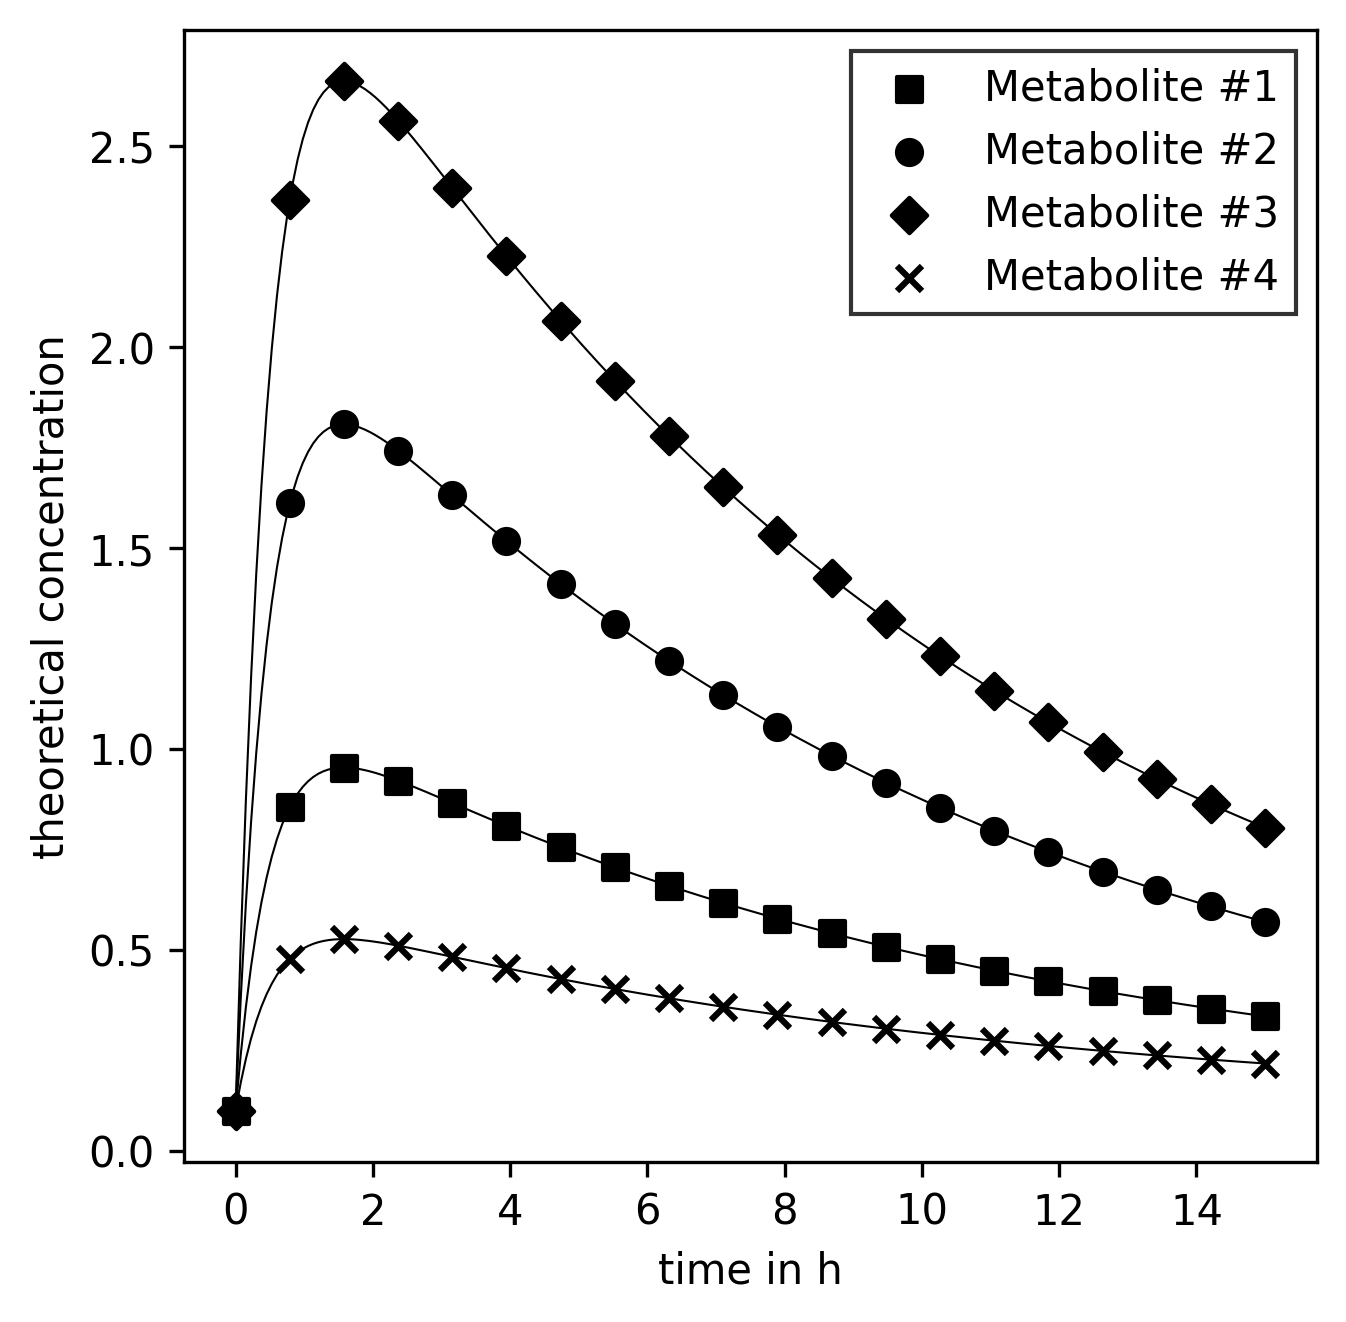

In [7]:
toy_k = np.array([[[2,.1,1,0,.1],
                   [2,.1,2,0,.1],
                   [2,.1,3,0,.1],
                   [2,.1,.5,0,.1]]])

tmp_k = toy_k[0]

plt.figure(dpi=300,figsize=(5,5))
plt.subplot(111,box_aspect=1)
markers = ['s','o','D','x']
i = 0
for k in tmp_k:
    timepoints = np.linspace(0,15,200)
    plt.plot(timepoints,em.bateman(timepoints,k),color='k',linewidth=.5)
    timepoints = np.linspace(0,15,20)
    plt.scatter(timepoints,em.bateman(timepoints,k),color='k',marker=markers[i],label='Metabolite #{}'.format(i+1))
    i += 1
plt.legend(edgecolor='k',fancybox=False)
plt.xlabel('time in h')
plt.ylabel('theoretical concentration')
plt.show()

# Figure 1

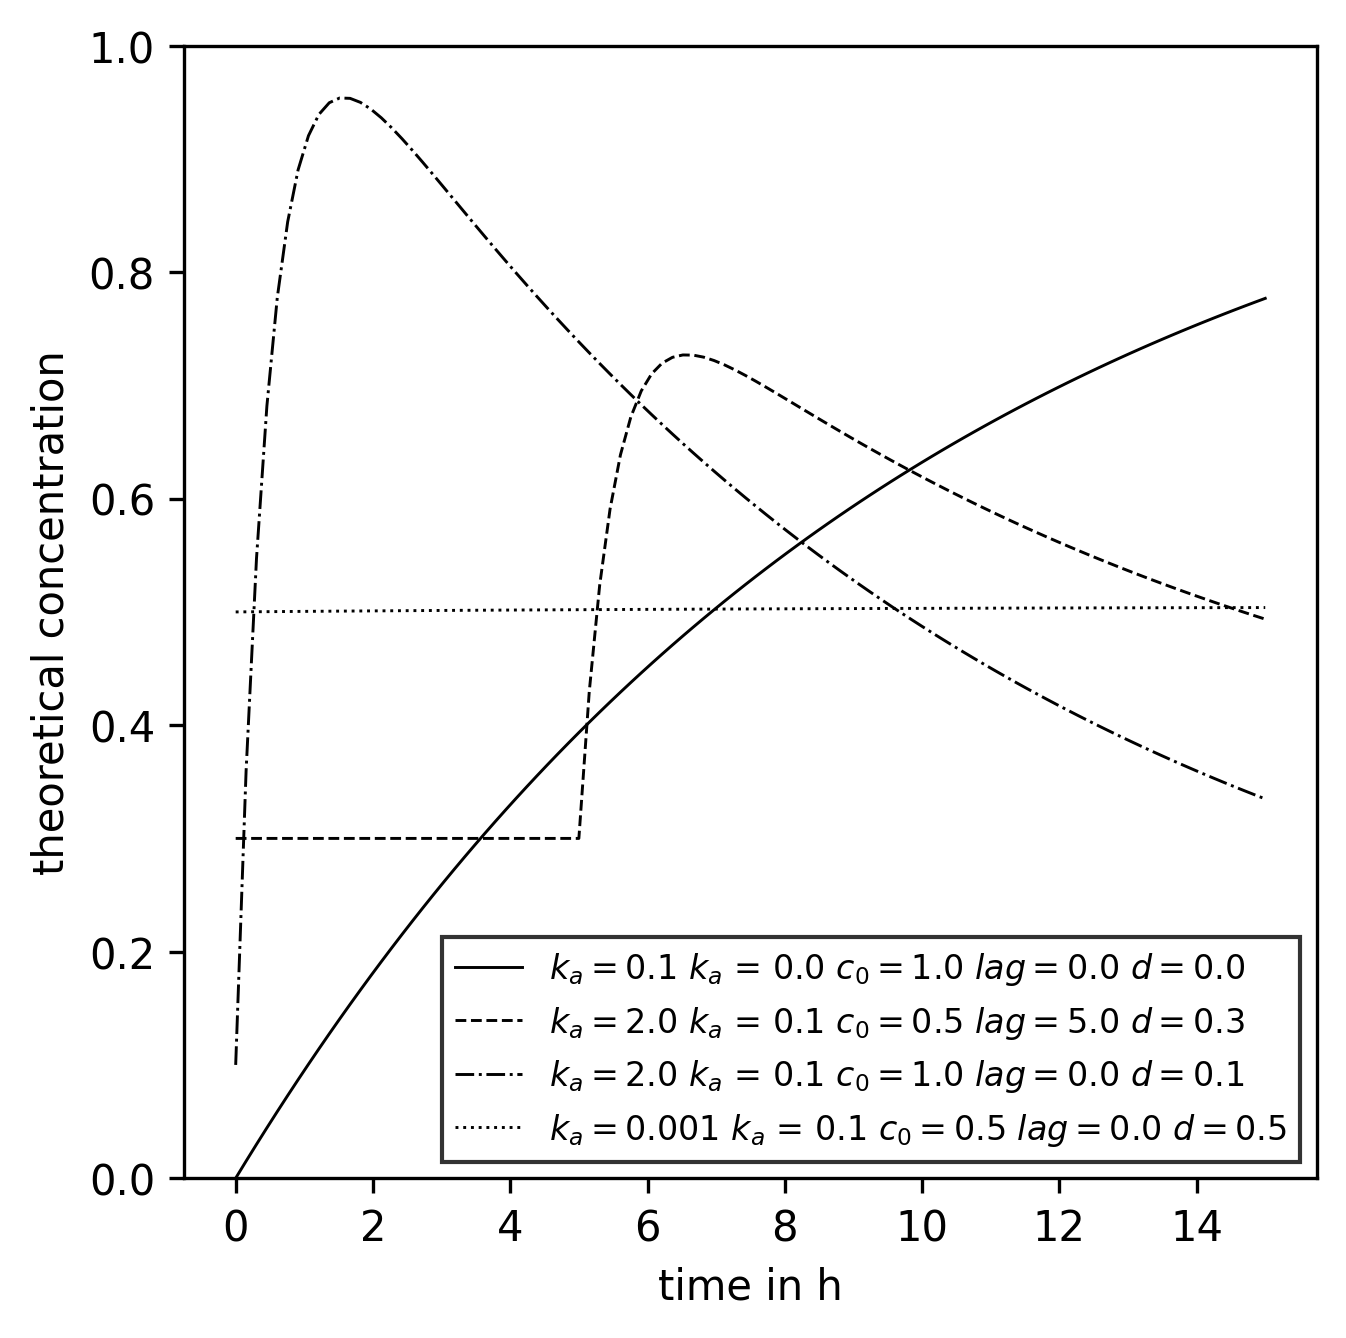

In [8]:
toy_k = np.array([[[.1,0,1,0,0],
                   [2,.1,.5,5,.3],
                   [2,.1,1,0,.1],
                   [.001,.1,.5,0,.5]]])
timepoints = np.linspace(0,15,100)
tmp_k = toy_k[0]

plt.figure(dpi=300,figsize=(5,5))
plt.subplot(111,box_aspect=1)
markers = ['-','--','-.',':']
i = 0
for k in tmp_k:
    l = r'$k_a = $'+str(k[0])+r' $k_a$ = '+str(k[1])+r' $c_0 = $'+str(k[2])+r' $lag = $'+str(k[3])+r' $d = $'+str(k[4])
    plt.plot(timepoints,em.bateman(timepoints,k),color='k',label=l,linestyle=markers[i],linewidth=.7)
    i += 1
plt.legend(edgecolor='k',fancybox=False,fontsize=8)
plt.xlabel('time in h')
plt.ylabel('theoretical concentration')
plt.ylim(0,1)
plt.show()

# Synthetic Data Results

In [9]:
def significance_star(pvalue):
    '''
    Prints correct number of stars for the significance level.
    -
    Input
    pvalue      value of probability
    -
    Output      
    string      string with correct number of stars for significant results and - for no significance
    '''
    
    assert pvalue >= 0
    
    if pvalue <= .001:
        return '***'
    elif pvalue <= .01:
        return '**'
    elif pvalue <= .05:
        return '*'
    else:
        return '-'
    
def SD(true,fit):
    return np.sqrt(np.sum((true-fit)**2)/len(true))

def ratio_SD(true,fit):
    y = fit/true
    return np.std(y/np.mean(y))

diagnosis = {'SD':SD,
             'ratio_SD':ratio_SD,
             'rSD':ratio_SD,
            }

In [10]:
def plot_performance(diagnosis_name,results_sv,with_pqn=True):
    diagnosis_func = diagnosis[diagnosis_name]
    maximum = 0
    # list of all goodness of fit estimates
    tmp_pqn      = []
    tmp_em_full  = []
    tmp_mix_full = []
    tmp_em_mini  = []
    tmp_mix_mini = []
    # read out how many replicates there are in the dataset
    n_replicates = len(results_sv['PQN'])
    # loop over all replicates
    for n_replicate in range(n_replicates):
        sv_vector  = results_sv['TRUE'][n_replicate]
        # loop over all normalization methods
        for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
            tmp_sv = results_sv[method][n_replicate]
            tmp_diagnosis = diagnosis_func(sv_vector,tmp_sv)
            tmp_list.append(tmp_diagnosis)
        
    # plot the diagnosis parameters
    rand = np.random.uniform(-.1,.1,n_replicates)
    nr = 0
    for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
        if method == 'PQN' and with_pqn==False:
            pass
        else:
            plt.scatter(np.ones(n_replicates)*nr+rand,tmp_list,color=colors[nr],marker='.',s=20,edgecolor='k',linewidth=.2)
            plt.plot([nr-.2,nr+.2],[np.mean(tmp_list),np.mean(tmp_list)],color='k')
        print('{:10} mean = {:5.3f} std = {:5.3f}'.format(method,np.mean(tmp_list),np.std(tmp_list)))
        nr += 1
        

    # significances
    tmp_dic = {'PQN':tmp_pqn,'EM_full':tmp_em_full,'EM_mini':tmp_em_mini,'MIX_full':tmp_mix_full,'MIX_mini':tmp_mix_mini}
    tmp_loc = {'PQN':0,'EM_full':1,'EM_mini':2,'MIX_full':3,'MIX_mini':4}
    if np.max([tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]) > maximum:
        maximum = np.max([tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini])
    height          = maximum*1.1
    bracket_size    = .01
    text_offset     = .01
    height_increase = .05*maximum
    print('------- P VALUES ------')
    p_df = pd.DataFrame(columns=tmp_loc.keys(),index=tmp_loc.keys(),dtype=np.float64)
    for i,j in combinations(tmp_dic.keys(),2):
#         test_result = ss.mannwhitneyu(tmp_dic[i],tmp_dic[j])
        test_result = ss.wilcoxon(tmp_dic[i],tmp_dic[j])
        print('{:15} {:15} {:8.2e} {}'.format(i,j,test_result.pvalue,significance_star(test_result.pvalue)))
        p_df.loc[i,j] = test_result.pvalue
        if test_result.pvalue <= .05:
            if i == 'PQN' and with_pqn == False:
                pass
            else:
                plt.plot(np.array([tmp_loc[i],tmp_loc[i],tmp_loc[j],tmp_loc[j]]),
                         [height-maximum*bracket_size,height,height,height-maximum*bracket_size],
                         'k',
                         linewidth=.5
                        )
                plt.text(np.mean([tmp_loc[i],tmp_loc[j]]),
                         height+maximum*text_offset,
                         significance_star(test_result.pvalue),
                         ha='center',
                         va='center',
                         fontsize=8
                        )
                height += height_increase
    return nr, p_df

def plot_points(diagnosis_name,results_sv):
    diagnosis_func = diagnosis[diagnosis_name]
    maximum = 0
    # list of all goodness of fit estimates
    tmp_pqn      = []
    tmp_em_full  = []
    tmp_mix_full = []
    tmp_em_mini  = []
    tmp_mix_mini = []
    # read out how many replicates there are in the dataset
    n_replicates = len(results_sv['PQN'])
    # loop over all replicates
    for n_replicate in range(n_replicates):
        sv_vector  = results_sv['TRUE'][n_replicate]
        # loop over all normalization methods
        for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
            tmp_sv = results_sv[method][n_replicate]
            tmp_diagnosis = diagnosis_func(sv_vector,tmp_sv)
            tmp_list.append(tmp_diagnosis)
    
    means = []
    stds   = []
    for tmp_list in [tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]:
        means.append(np.mean(tmp_list))
        stds.append(np.std(tmp_list))
    return means, stds

## Figures 4, S6, S7

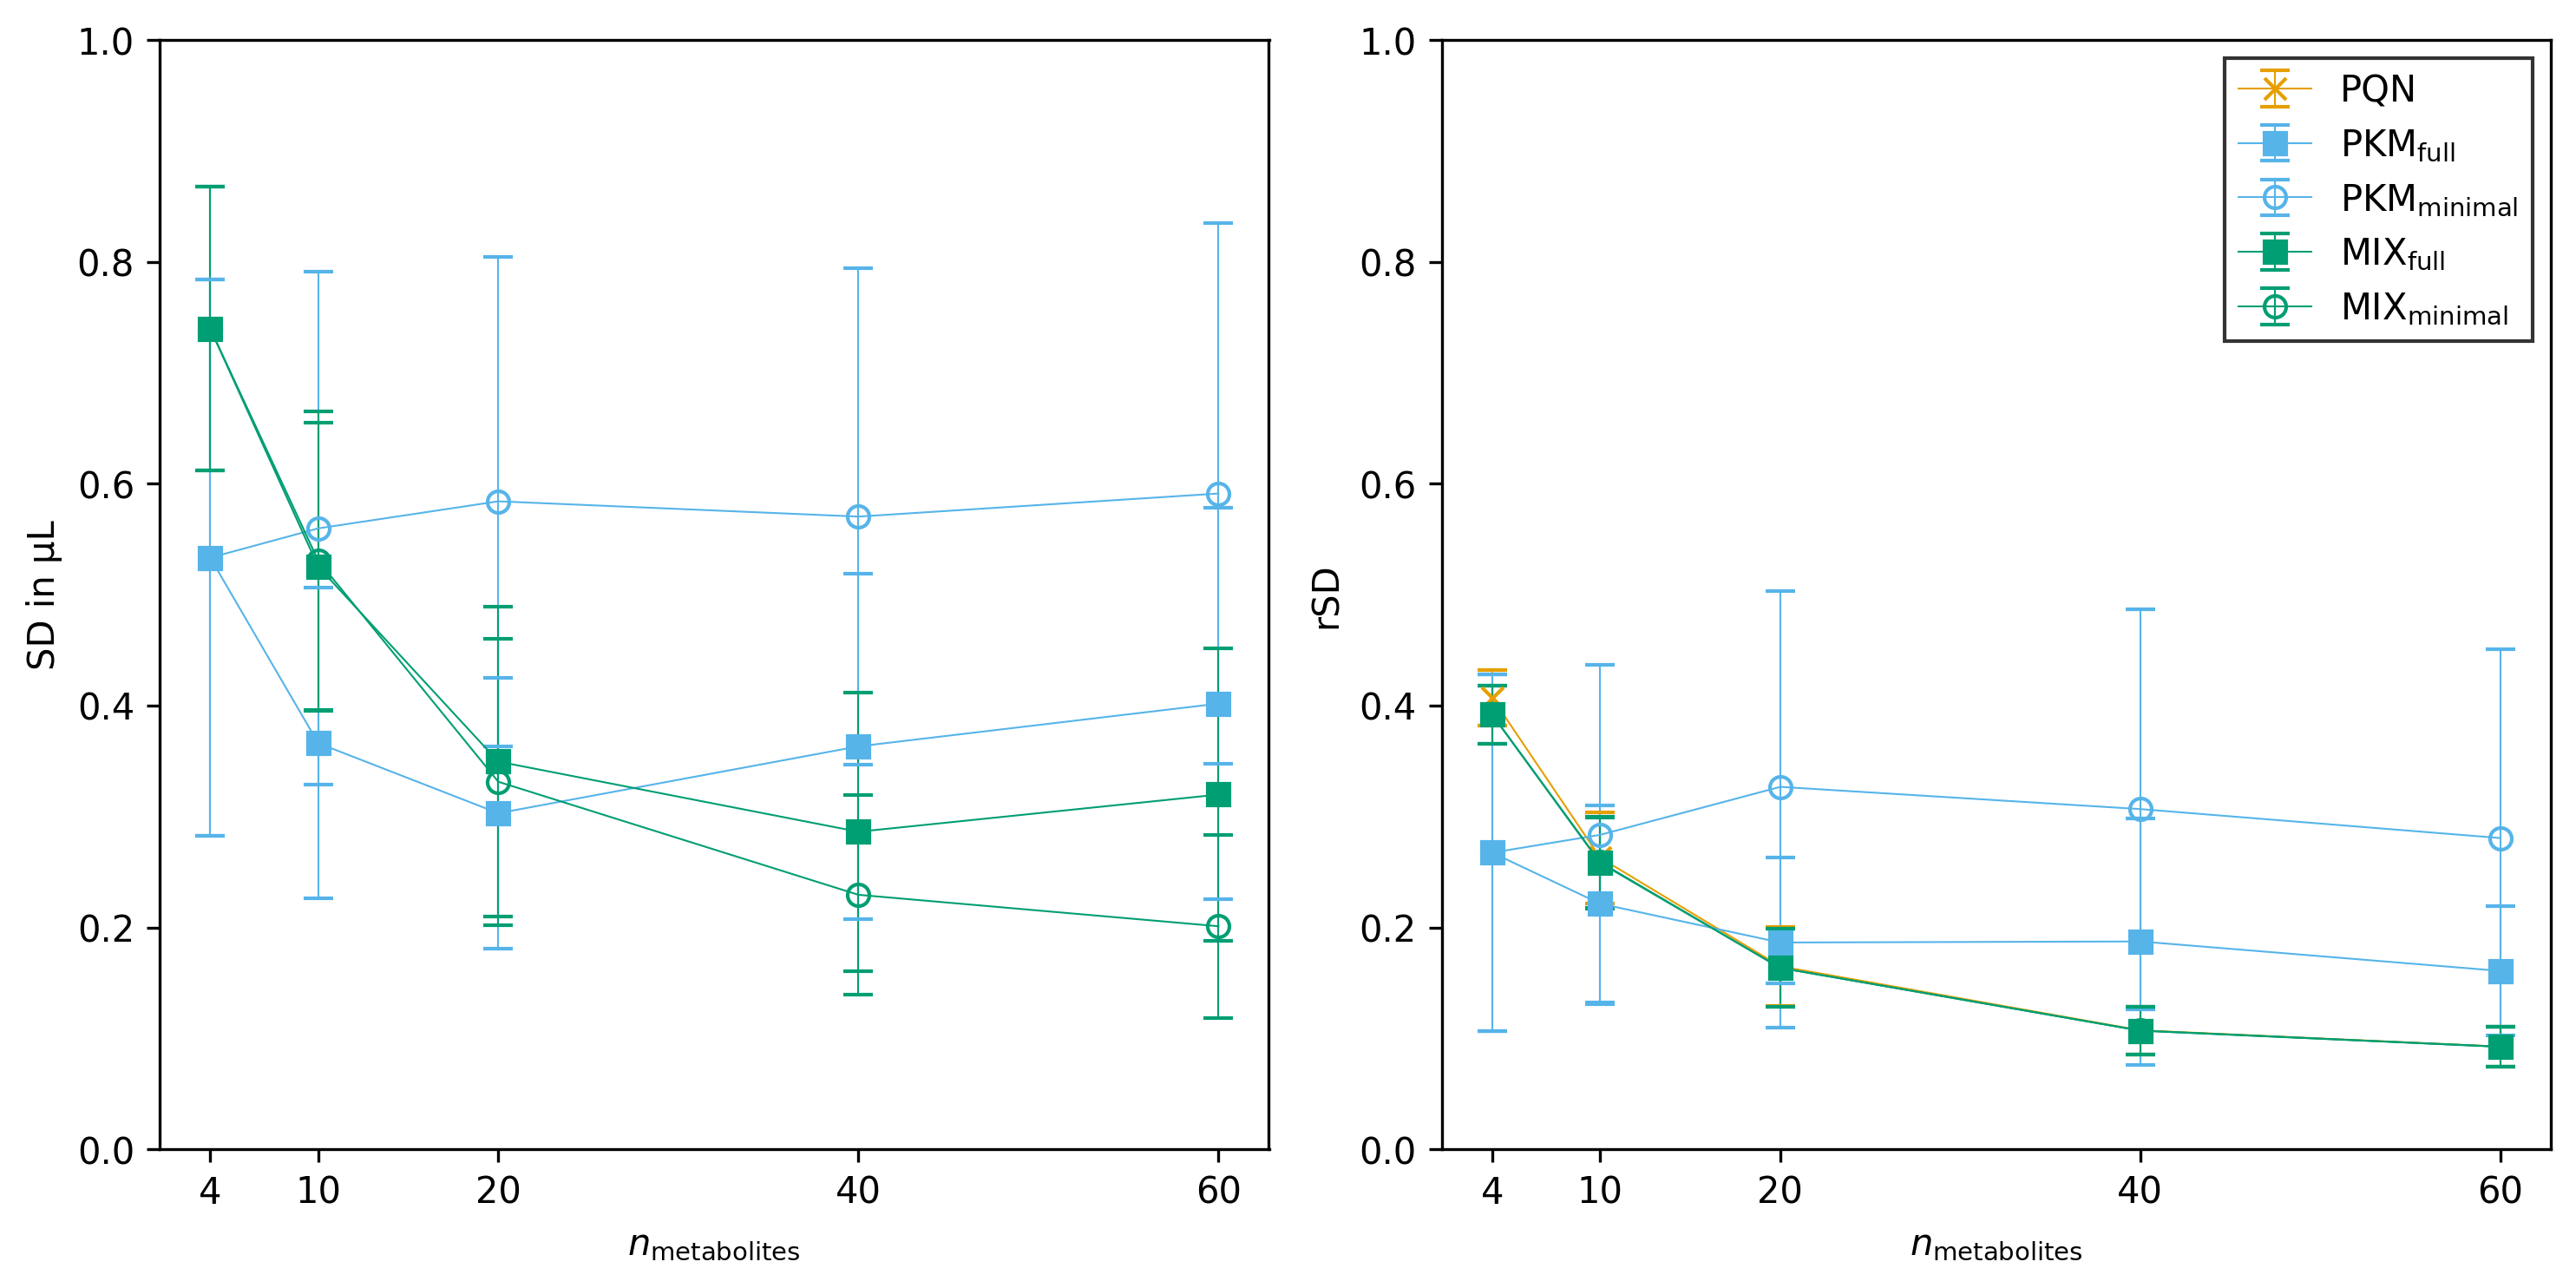

In [11]:
# load data
error_sigma   = .2
path          = 'v3' # v1 for Figure S6, v2 for Figure S7
base          = 'synthetic_data/simulation_results'
n_metabolites_list = np.array([4,10,20,40,60])
plt.figure(dpi=300,figsize=(10,5))


######## Subplot 1
markers = ['x','s','o','s','o']
colors  = ['#E69F00','#56B4E9','#56B4E9','#009E73','#009E73']
fcolors = ['#E69F00','#56B4E9','none','#009E73','none']
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']
labels  = ['PQN',r'EM$_{\rmfull}$',r'EM$_{\rmminimal}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']
plt.subplot(121,box_aspect=1)
# plt.title('version = {} \nerror_sigma = {:.1f}'.format(path,error_sigma))
diagnosis_name = 'SD'
plt.ylabel(f'{diagnosis_name} in μL')
points = []
stds   = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp, std = plot_points(diagnosis_name,results_sv)
    points.append(tmp)
    stds.append(std)
points = np.array(points)
stds = np.array(stds)

# write out dataframes for means and stds 
SD_results = pd.DataFrame(index=methods,columns=[f'{path} {i} mean' for i in n_metabolites_list]+[f'{path} {i} std' for i in n_metabolites_list])
SD_results.iloc[:,:len(n_metabolites_list)] = points.T
SD_results.iloc[:,len(n_metabolites_list):] = stds.T

for nr, label in enumerate(methods):
    if nr == 0:
        pass
    else:
        plt.errorbar(n_metabolites_list,points[:,nr],yerr=stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=4,label=labels[nr],mfc=fcolors[nr])
plt.xlabel(r'$n_{\rm metabolites}$')
plt.xticks(n_metabolites_list)
plt.ylim(0,1)

######## Subplot 2
markers = ['x','s','o','s','o']
colors  = ['#E69F00','#56B4E9','#56B4E9','#009E73','#009E73']
fcolors  = ['#E69F00','#56B4E9','none','#009E73','none']
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']
labels  = ['PQN',r'PKM$_{\rmfull}$',r'PKM$_{\rmminimal}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']

plt.subplot(122,box_aspect=1)
# plt.title('version = {} \nerror_sigma = {:.1f}'.format(path,error_sigma))
diagnosis_name = 'ratio_SD'
plt.ylabel(f'rSD')
points = []
stds   = []
for n_metabolites in n_metabolites_list:
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)
    tmp, std = plot_points(diagnosis_name,results_sv)
    points.append(tmp)
    stds.append(std)
points = np.array(points)
stds = np.array(stds)

# write out dataframes for means and stds 
rSD_results = pd.DataFrame(index=methods,columns=[f'{path} {i} mean' for i in n_metabolites_list]+[f'{path} {i} std' for i in n_metabolites_list])
rSD_results.iloc[:,:len(n_metabolites_list)] = points.T
rSD_results.iloc[:,len(n_metabolites_list):] = stds.T

for nr, label in enumerate(methods):
    plt.errorbar(n_metabolites_list,points[:,nr],yerr=stds[:,nr],color=colors[nr],marker=markers[nr],linewidth=.5,capsize=4,label=labels[nr],mfc=fcolors[nr])
plt.xlabel(r'$n_{\rm metabolites}$')
plt.xticks(n_metabolites_list)
plt.ylim(0,1)

######## Concluding Commands
plt.legend(edgecolor='k',fancybox=False)
plt.tight_layout()
plt.show()

## Figure 5, S8, S9

PQN        mean = 0.364 std = 0.194
EM_full    mean = 0.402 std = 0.176
EM_mini    mean = 0.591 std = 0.244
MIX_full   mean = 0.320 std = 0.132
MIX_mini   mean = 0.201 std = 0.082
------- P VALUES ------
PQN             EM_full         5.00e-02 -
PQN             EM_mini         3.20e-10 ***
PQN             MIX_full        1.90e-02 *
PQN             MIX_mini        5.43e-12 ***
EM_full         EM_mini         2.24e-07 ***
EM_full         MIX_full        3.88e-06 ***
EM_full         MIX_mini        1.58e-14 ***
EM_mini         MIX_full        9.71e-13 ***
EM_mini         MIX_mini        5.60e-18 ***
MIX_full        MIX_mini        9.71e-13 ***


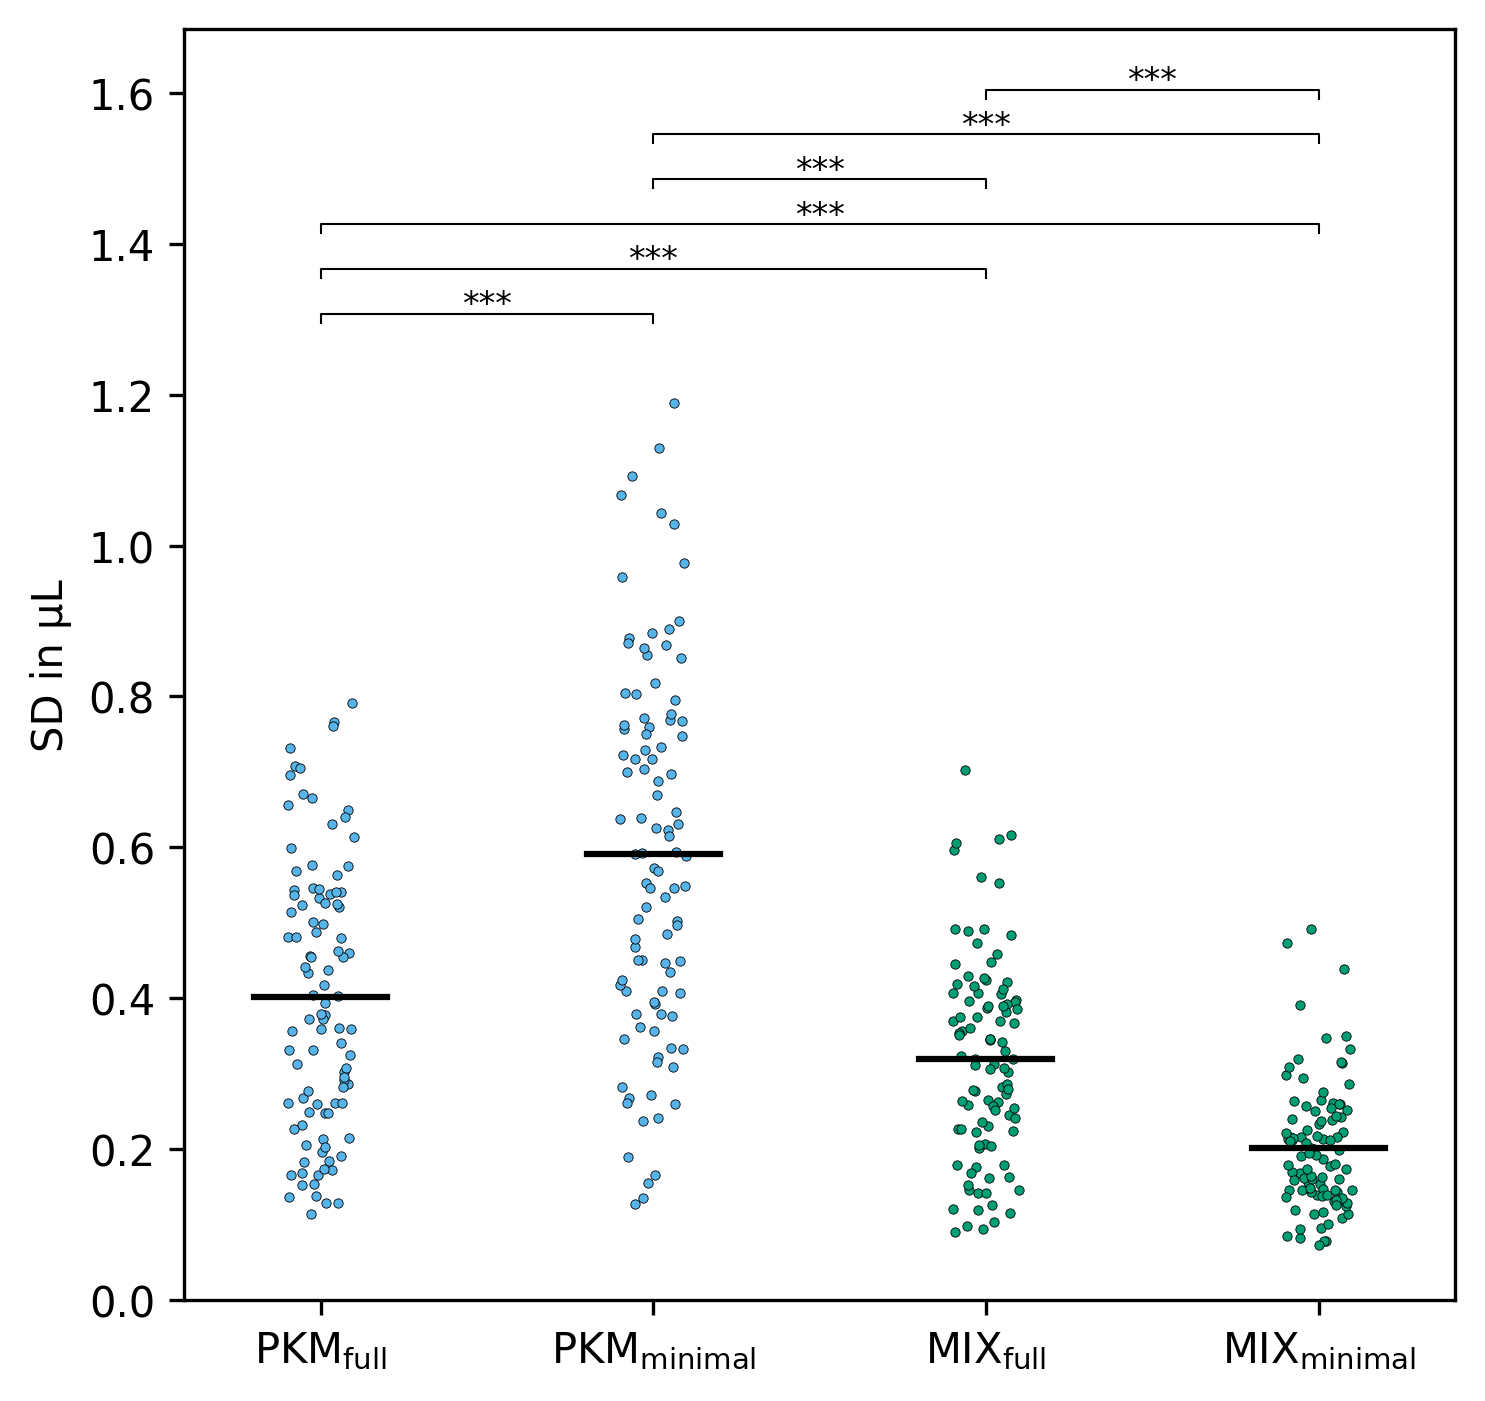

In [12]:
# load data
error_sigma   = .2
n_metabolites = 60
path          = 'v3' # v1 for Figure S8, v2 for Figure S9
base          = 'synthetic_data/simulation_results'
colors  = ['#E69F00','#56B4E9','#56B4E9','#009E73','#009E73']
with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
    results_time,results_sv,results_model,raw_values = pickle.load(file)
    
labels  = [r'PKM$_{\rmfull}$',r'PKM$_{\rmminimal}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']

# plot figure
plt.figure(dpi=300,figsize=(5,5))
ax = plt.subplot(111,box_aspect=1)

diagnosis_name = 'SD'
nr,p_df = plot_performance(diagnosis_name,results_sv,with_pqn=False)

plt.ylabel(diagnosis_name+' in μL')
plt.plot(0,0,color='b',label='PQN')
plt.plot(0,0,color='r',label='EM')
plt.plot(0,0,color='y',label='MIX')
plt.xticks(range(1,nr),labels)
plt.tight_layout()
y_min,y_max = ax.get_ylim()
x_min,x_max = ax.get_xlim()
ax.set_ylim(0,y_max)
ax.set_xlim(1+(4-x_max),x_max)
plt.show()

## Unused: Comparison of rSD

PQN        mean = 0.093 std = 0.018
EM_full    mean = 0.161 std = 0.058
EM_mini    mean = 0.281 std = 0.170
MIX_full   mean = 0.092 std = 0.018
MIX_mini   mean = 0.092 std = 0.018
------- P VALUES ------
PQN             EM_full         4.22e-17 ***
PQN             EM_mini         4.53e-18 ***
PQN             MIX_full        6.02e-11 ***
PQN             MIX_mini        2.69e-16 ***
EM_full         EM_mini         2.39e-09 ***
EM_full         MIX_full        3.86e-17 ***
EM_full         MIX_mini        3.86e-17 ***
EM_mini         MIX_full        4.53e-18 ***
EM_mini         MIX_mini        4.53e-18 ***
MIX_full        MIX_mini        3.96e-01 -


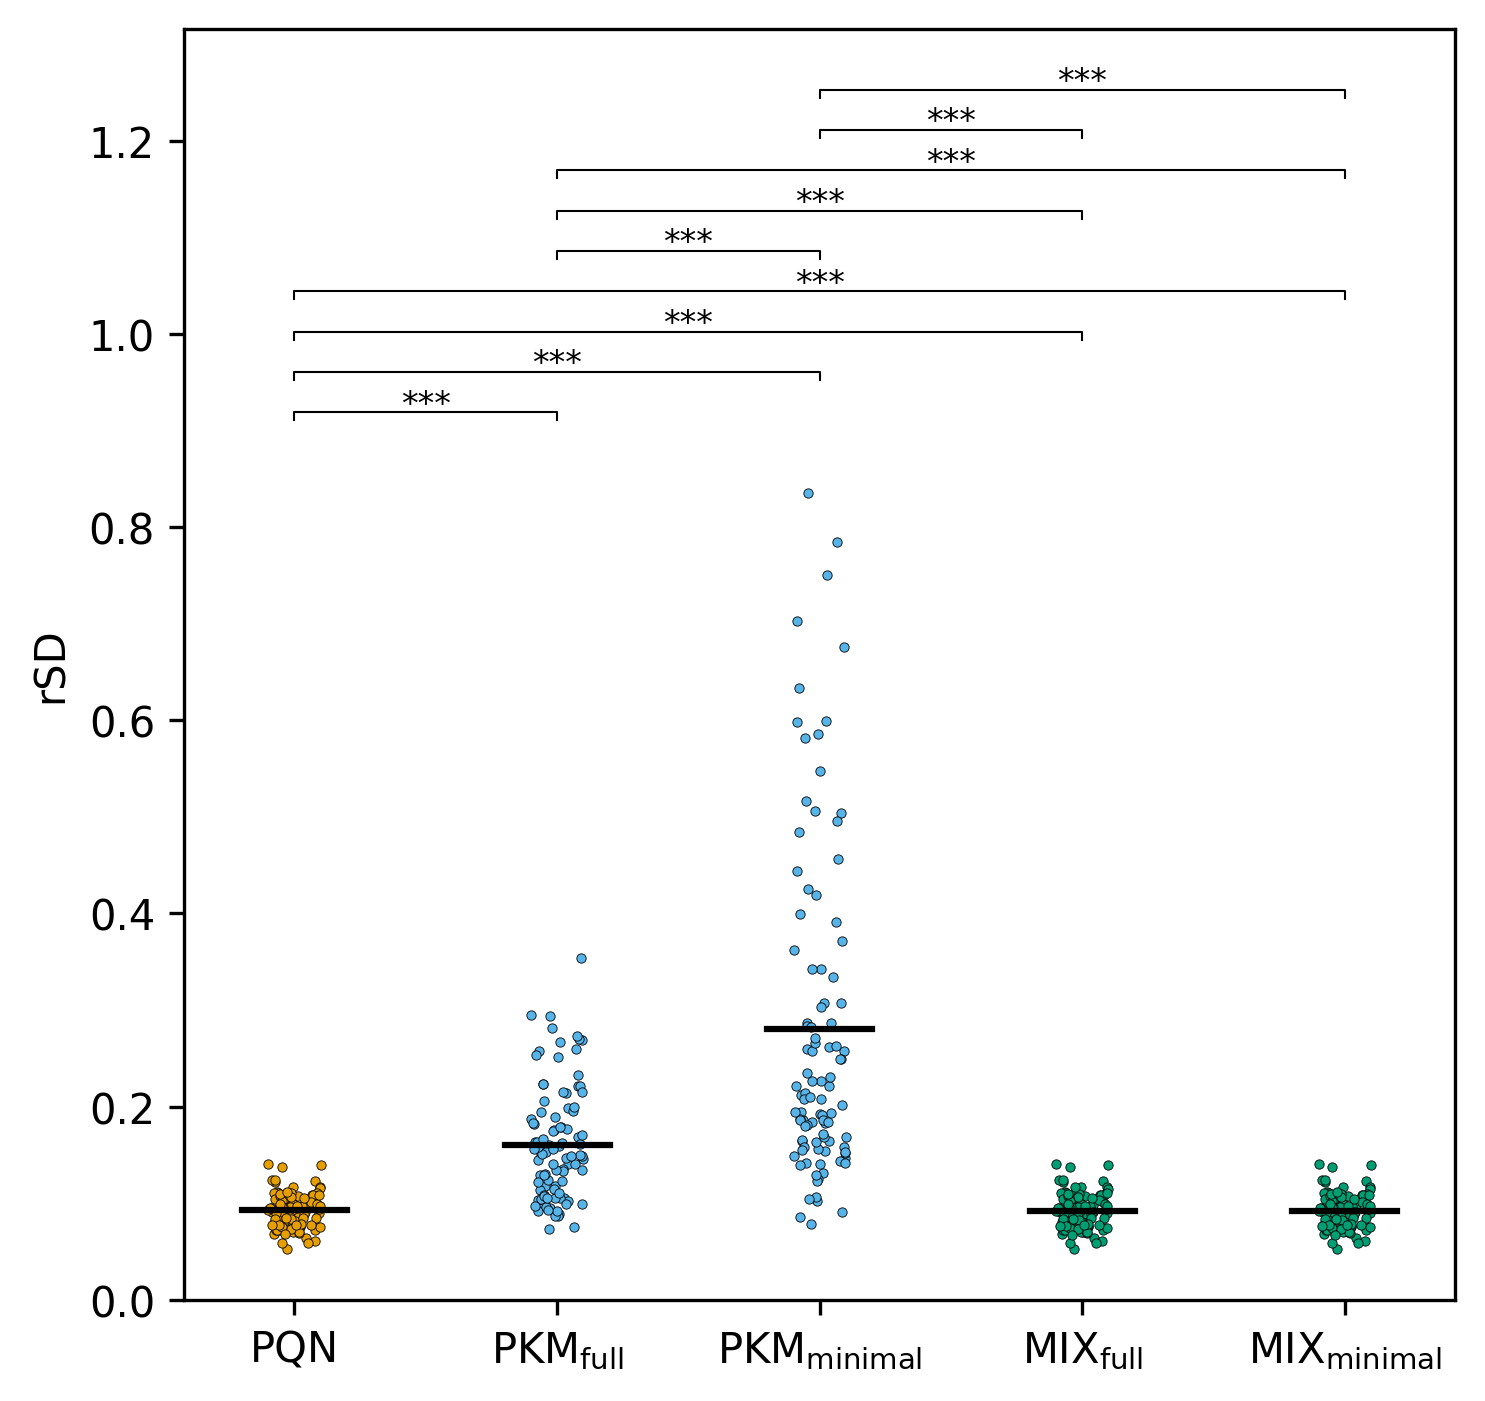

In [13]:
# load data
error_sigma   = .2
n_metabolites = 60
path          = 'v3' # v1, v2 also possible
base          = 'synthetic_data/simulation_results'
with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
    results_time,results_sv,results_model,raw_values = pickle.load(file)
    
labels  = ['PQN',r'PKM$_{\rmfull}$',r'PKM$_{\rmminimal}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']

# plot figure
plt.figure(dpi=300,figsize=(5,5))
ax = plt.subplot(111,box_aspect=1)

diagnosis_name = 'rSD'
nr, p_df = plot_performance(diagnosis_name,results_sv)

plt.ylabel(diagnosis_name)
plt.plot(0,0,color='b',label='PQN')
plt.plot(0,0,color='r',label='EM')
plt.plot(0,0,color='y',label='MIX')
plt.xticks(range(nr),labels)
plt.tight_layout()
y_min,y_max = ax.get_ylim()
ax.set_ylim(0,y_max)
plt.show()

## Figure 3

In [14]:
from sklearn.metrics import r2_score

def unflattener(vector,n_metabolites,n_timepoints):
    tensor = vector.reshape(n_metabolites,n_timepoints,order='F')
    return tensor

def normalizer(mtilde,vsweat):
    c = mtilde/vsweat[:,None,:]
    return c

rep = 11
# load data
error_sigma   = .2
n_metabolites = 60
path          = 'v3'
base          = 'synthetic_data/simulation_results'
with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
    results_time,results_sv,results_model,raw_values = pickle.load(file)
    
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']
c_true  = np.array(raw_values['C'])
v_true  = np.array(results_sv['TRUE'])
m_tilde = np.array(raw_values['M'])
c_true0 = c_true[:,:,0]
c_true_rel = c_true/c_true0[:,:,None]

relative
R²  PQN                  0.856
rSD PQN                  0.093
R²  EM_full              0.750
rSD EM_full              0.161
R²  MIX_full             0.856
rSD MIX_full             0.092
absolute
R²  EM_full              0.717
rSD EM_full              0.402
R²  MIX_full             0.824
rSD MIX_full             0.320


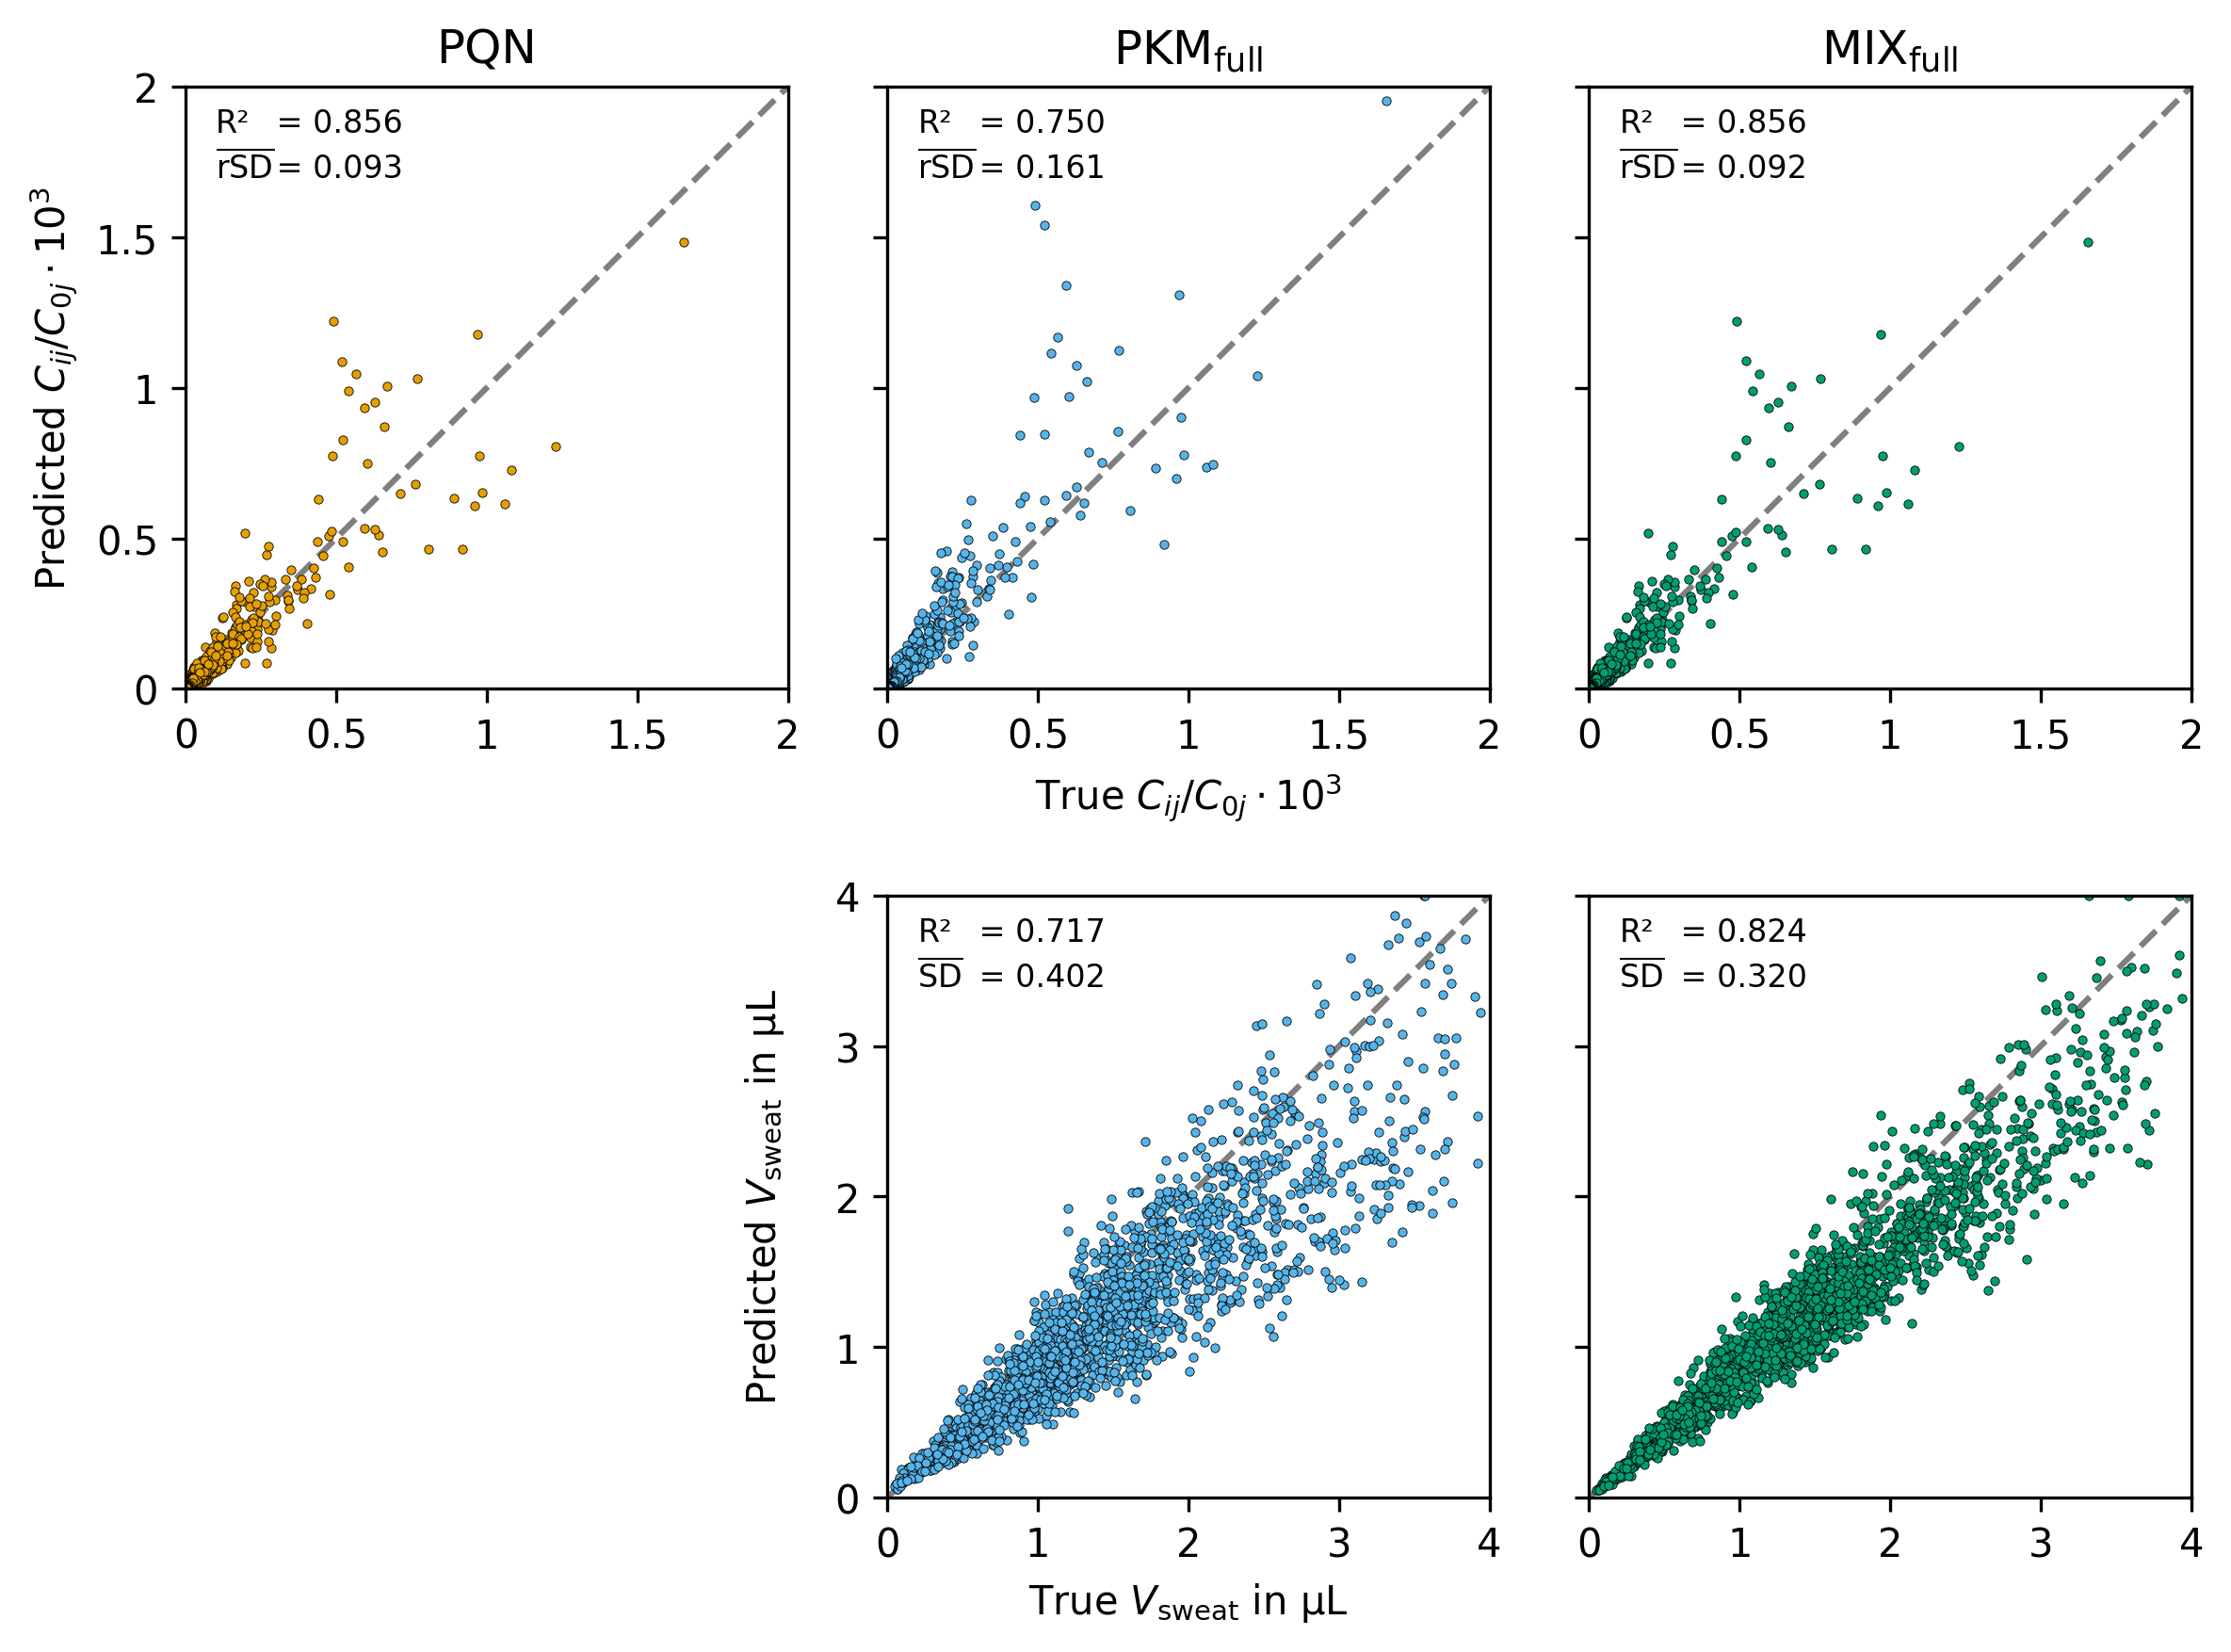

In [15]:
labels  = ['PQN',r'PKM$_{\rmfull}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']
methods = ['PQN','EM_full','MIX_full']
colors  = ['#E69F00','#56B4E9','#009E73','#009E73']
c_true  = np.array(raw_values['C'])
v_true  = np.array(results_sv['TRUE'])
m_tilde = np.array(raw_values['M'])
c_true0 = c_true[:,:,0]
c_true_rel = c_true/c_true0[:,:,None]
n = 0
plt.figure(dpi=300,figsize=(8,6))

#################
## FIRST ROW
#################
print('relative')


for method in methods:
    tmp_v = np.array(results_sv[method])
    fit_c = normalizer(m_tilde,tmp_v)
    fit_c0 = fit_c[:,:,0]
    fit_c_rel = fit_c/fit_c0[:,:,None]
    n += 1
    ax = plt.subplot(2,3,n,box_aspect=1)
#     plt.scatter(c_true[:,:],fit_c[:,:],color=colors[n-1],marker='.',s=20,edgecolor='k',linewidth=.2)
    plt.scatter(c_true_rel.flatten(),fit_c_rel.flatten(),color=colors[n-1],marker='.',s=20,edgecolor='k',linewidth=.2)
    print('R²  {:20} {:.3f}'.format(method,r2_score(c_true_rel.flatten(),fit_c_rel.flatten())))
    # calculate rSD
    rsd_list = []
    for bla_true,bla_pred in zip(v_true,tmp_v):
        rsd_list.append(ratio_SD(bla_true,bla_pred))
    print('rSD {:20} {:.3f}'.format(method,np.mean(rsd_list)))
    plt.text(270,1850,' = {:.3f}'.format(r2_score(c_true_rel.flatten(),fit_c_rel.flatten())),size=8)
    plt.text(270,1700,' = {:.3f}'.format(np.mean(rsd_list)),size=8)
    plt.text(100,1850,'R²',size=8)
    plt.text(100,1700,r'$\overline{\rm rSD}$',size=8)
    plt.title(labels[n-1])
    
    lb = np.min([ax.get_ylim(),ax.get_xlim()])
    ub = np.max([ax.get_ylim(),ax.get_xlim()])
    lb,ub = 0,2000
    plt.plot([lb,ub],[lb,ub],'k--',alpha=.5,zorder=0)
    plt.xlim(lb,ub)
    plt.ylim(lb,ub)
    if n == 1:
#         plt.ylabel(r'$Q^{\rm PQN}(t)/Q^{\rm PQN}(0)$')
        plt.ylabel(r'Predicted $C_{ij}/C_{0j} \cdot 10^3$')
        plt.yticks([0,500,1000,1500,2000],['0','0.5','1','1.5','2'])
    elif n ==2:
#         plt.ylabel(r'$V_{\rm sweat}^{\rm PKM}(t)/V_{\rm sweat}^{\rm PKM}(0)$')
        plt.xlabel(r'True $C_{ij}/C_{0j} \cdot 10^3$')
    else:
#         plt.ylabel(r'$V_{\rm sweat}^{\rm MIX}(t)/V_{\rm sweat}^{\rm MIX}(0)$')
        pass
    if n > 1:
        plt.yticks([0,500,1000,1500,2000],[])
    plt.xticks([0,500,1000,1500,2000],['0','0.5','1','1.5','2'])

#################
## SECOND ROW
#################
print('absolute')

labels  = [r'PKM$_{\rmfull}$',r'MIX$_{\rmfull}$',r'MIX$_{\rmminimal}$']
methods = ['EM_full','MIX_full']
colors  = ['#56B4E9','#009E73','#009E73']

n = 4
for method in methods:
    tmp_v = np.array(results_sv[method])
    n += 1
    ax = plt.subplot(2,3,n,box_aspect=1)
#     plt.scatter(c_true[:,:],fit_c[:,:],color=colors[n-1],marker='.',s=20,edgecolor='k',linewidth=.2)
    plt.scatter(v_true,tmp_v,color=colors[n-5],marker='.',s=20,edgecolor='k',linewidth=.2)
    print('R²  {:20} {:.3f}'.format(method,r2_score(v_true.flatten(),tmp_v.flatten())))
#     plt.text(.2,3.6,'R² = {:.3f}'.format(r2_score(v_true.flatten(),tmp_v.flatten())))
    # calculate rSD
    sd_list = []
    for bla_true,bla_pred in zip(v_true,tmp_v):
        sd_list.append(SD(bla_true,bla_pred))
    print('rSD {:20} {:.3f}'.format(method,np.mean(sd_list)))
    plt.text(270/1000*2,1850/1000*2,' = {:.3f}'.format(r2_score(v_true.flatten(),tmp_v.flatten())),size=8)
    plt.text(270/1000*2,1700/1000*2,' = {:.3f}'.format(np.mean(sd_list)),size=8)
    plt.text(.2,1850/1000*2,'R²',size=8)
    plt.text(.2,1700/1000*2,r'$\overline{\rm SD}$',size=8)
#     plt.title(labels[n-5])
    
#     lb = np.min([ax.get_ylim(),ax.get_xlim()])
#     ub = np.max([ax.get_ylim(),ax.get_xlim()])
    lb,ub = 0,4
    plt.plot([lb,ub],[lb,ub],'k--',alpha=.5,zorder=0)
    plt.xlim(lb,ub)
    plt.ylim(lb,ub)
    if n ==6:
        plt.yticks([0,1,2,3,4],[])
    else:
        plt.yticks([0,1,2,3,4])
#         plt.ylabel(r'Predicted $V_{\rm sweat}$ in µL')
        plt.xlabel(r'True $V_{\rm sweat}$ in µL')

    
plt.subplot(2,3,4)
plt.xlim(lb,ub)
plt.ylim(lb,ub)
plt.text(3.7,2,r'Predicted $V_{\rm sweat}$ in µL',rotation=90,size=10,va='center',ha='left')
plt.axis('off')
plt.tight_layout()
plt.show()

# Real Data Results

In [16]:
# parameter properties
donors = ['Donor_1','Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47']
metabolites = ['Paraxanthine','Theobromine','Theophylline']
def parse_results(path):
    best_parameters = {}
    for donor in donors:
        tmp_dic = {}
        for metabolite in metabolites:
            # read in file from the output data that was used in the manuscript
            with open(f'real_data/{path}/{donor}_{metabolite}.txt','r') as file:
                lines  = file.readlines()
            parameters = []
            losses     = []
            for line in lines:
                tmp = []
                for l in line.split()[0:-1]:
                    tmp.append(float(l))
                parameters.append(tmp)
                losses.append(float(line.split()[-1]))

            # select fit with lowest loss
            if 'MIX' in path:
                best = parameters[np.argmin(losses)][1:]
            elif 'EM' in path:
                best = parameters[np.argmin(losses)]
            else:
                print('Parsing Error, could not identify model type. \n Either MIX or EM should be in path.')
            tmp_dic[metabolite] = best
        best_parameters[donor] = tmp_dic
    return best_parameters

In [17]:
def get_stds(path,verbose=True):
    best_parameters = parse_results(path)
    stds = []
    for donor in donors:
        k = []
        for metabolite in metabolites:
            tmp = best_parameters[donor][metabolite]
            ka = tmp[0]
            ke = tmp[1]+tmp[2]
            k.append([ka,ke])
        k = np.array(k)
        stds.append(np.std(k,axis=0))
    stds = np.array(stds)
    if verbose:
        print('      ka         ke')
        print('mean',np.mean(stds,axis=0))
        print('std ',np.std( stds,axis=0))
    return stds

def calculate_significances(tmp_dic,tmp_loc):
    # significances
    maximum = 0
    for key in tmp_dic:
        if np.max(tmp_dic[key]) > maximum:
            maximum = np.max(tmp_dic[key])
    height          = maximum*1.1
    bracket_size    = .01
    text_offset     = .01
    height_increase = .05*maximum
    print('------- P VALUES ------')
    for i,j in combinations(tmp_dic.keys(),2):
#         test_result = ss.mannwhitneyu(tmp_dic[i],tmp_dic[j])
        test_result = ss.wilcoxon(tmp_dic[i],tmp_dic[j],alternative='two-sided')
        print('{:15} {:15} {:8.2e} {}'.format(i,j,test_result.pvalue,significance_star(test_result.pvalue)))
        if test_result.pvalue <= .05:
                plt.plot(np.array([tmp_loc[i],tmp_loc[i],tmp_loc[j],tmp_loc[j]]),
                         [height-maximum*bracket_size,height,height,height-maximum*bracket_size],
                         'k',
                         linewidth=.5
                        )
                plt.text(np.mean([tmp_loc[i],tmp_loc[j]]),
                         height+maximum*text_offset,
                         significance_star(test_result.pvalue),
                         ha='center',
                         va='center',
                         fontsize=8
                        )
                height += height_increase

## Figure 8

EM_sub_2
      ka         ke
mean [0.95247448 0.01363635]
std  [1.08107397 0.0094187 ]
MIX_sub_2_n_EM
      ka         ke
mean [0.26701531 0.00368588]
std  [0.44238393 0.00344694]
MIX_sub_2_n_PQN
      ka         ke
mean [0.18709804 0.00326539]
std  [0.418638   0.00366264]
------- P VALUES ------
EM_sub_2        MIX_sub_2_n_EM  2.83e-05 ***
EM_sub_2        MIX_sub_2_n_PQN 2.17e-05 ***
MIX_sub_2_n_EM  MIX_sub_2_n_PQN 1.68e-02 *
------- P VALUES ------
EM_sub_2        MIX_sub_2_n_EM  4.50e-07 ***
EM_sub_2        MIX_sub_2_n_PQN 4.16e-07 ***
MIX_sub_2_n_EM  MIX_sub_2_n_PQN 2.42e-01 -


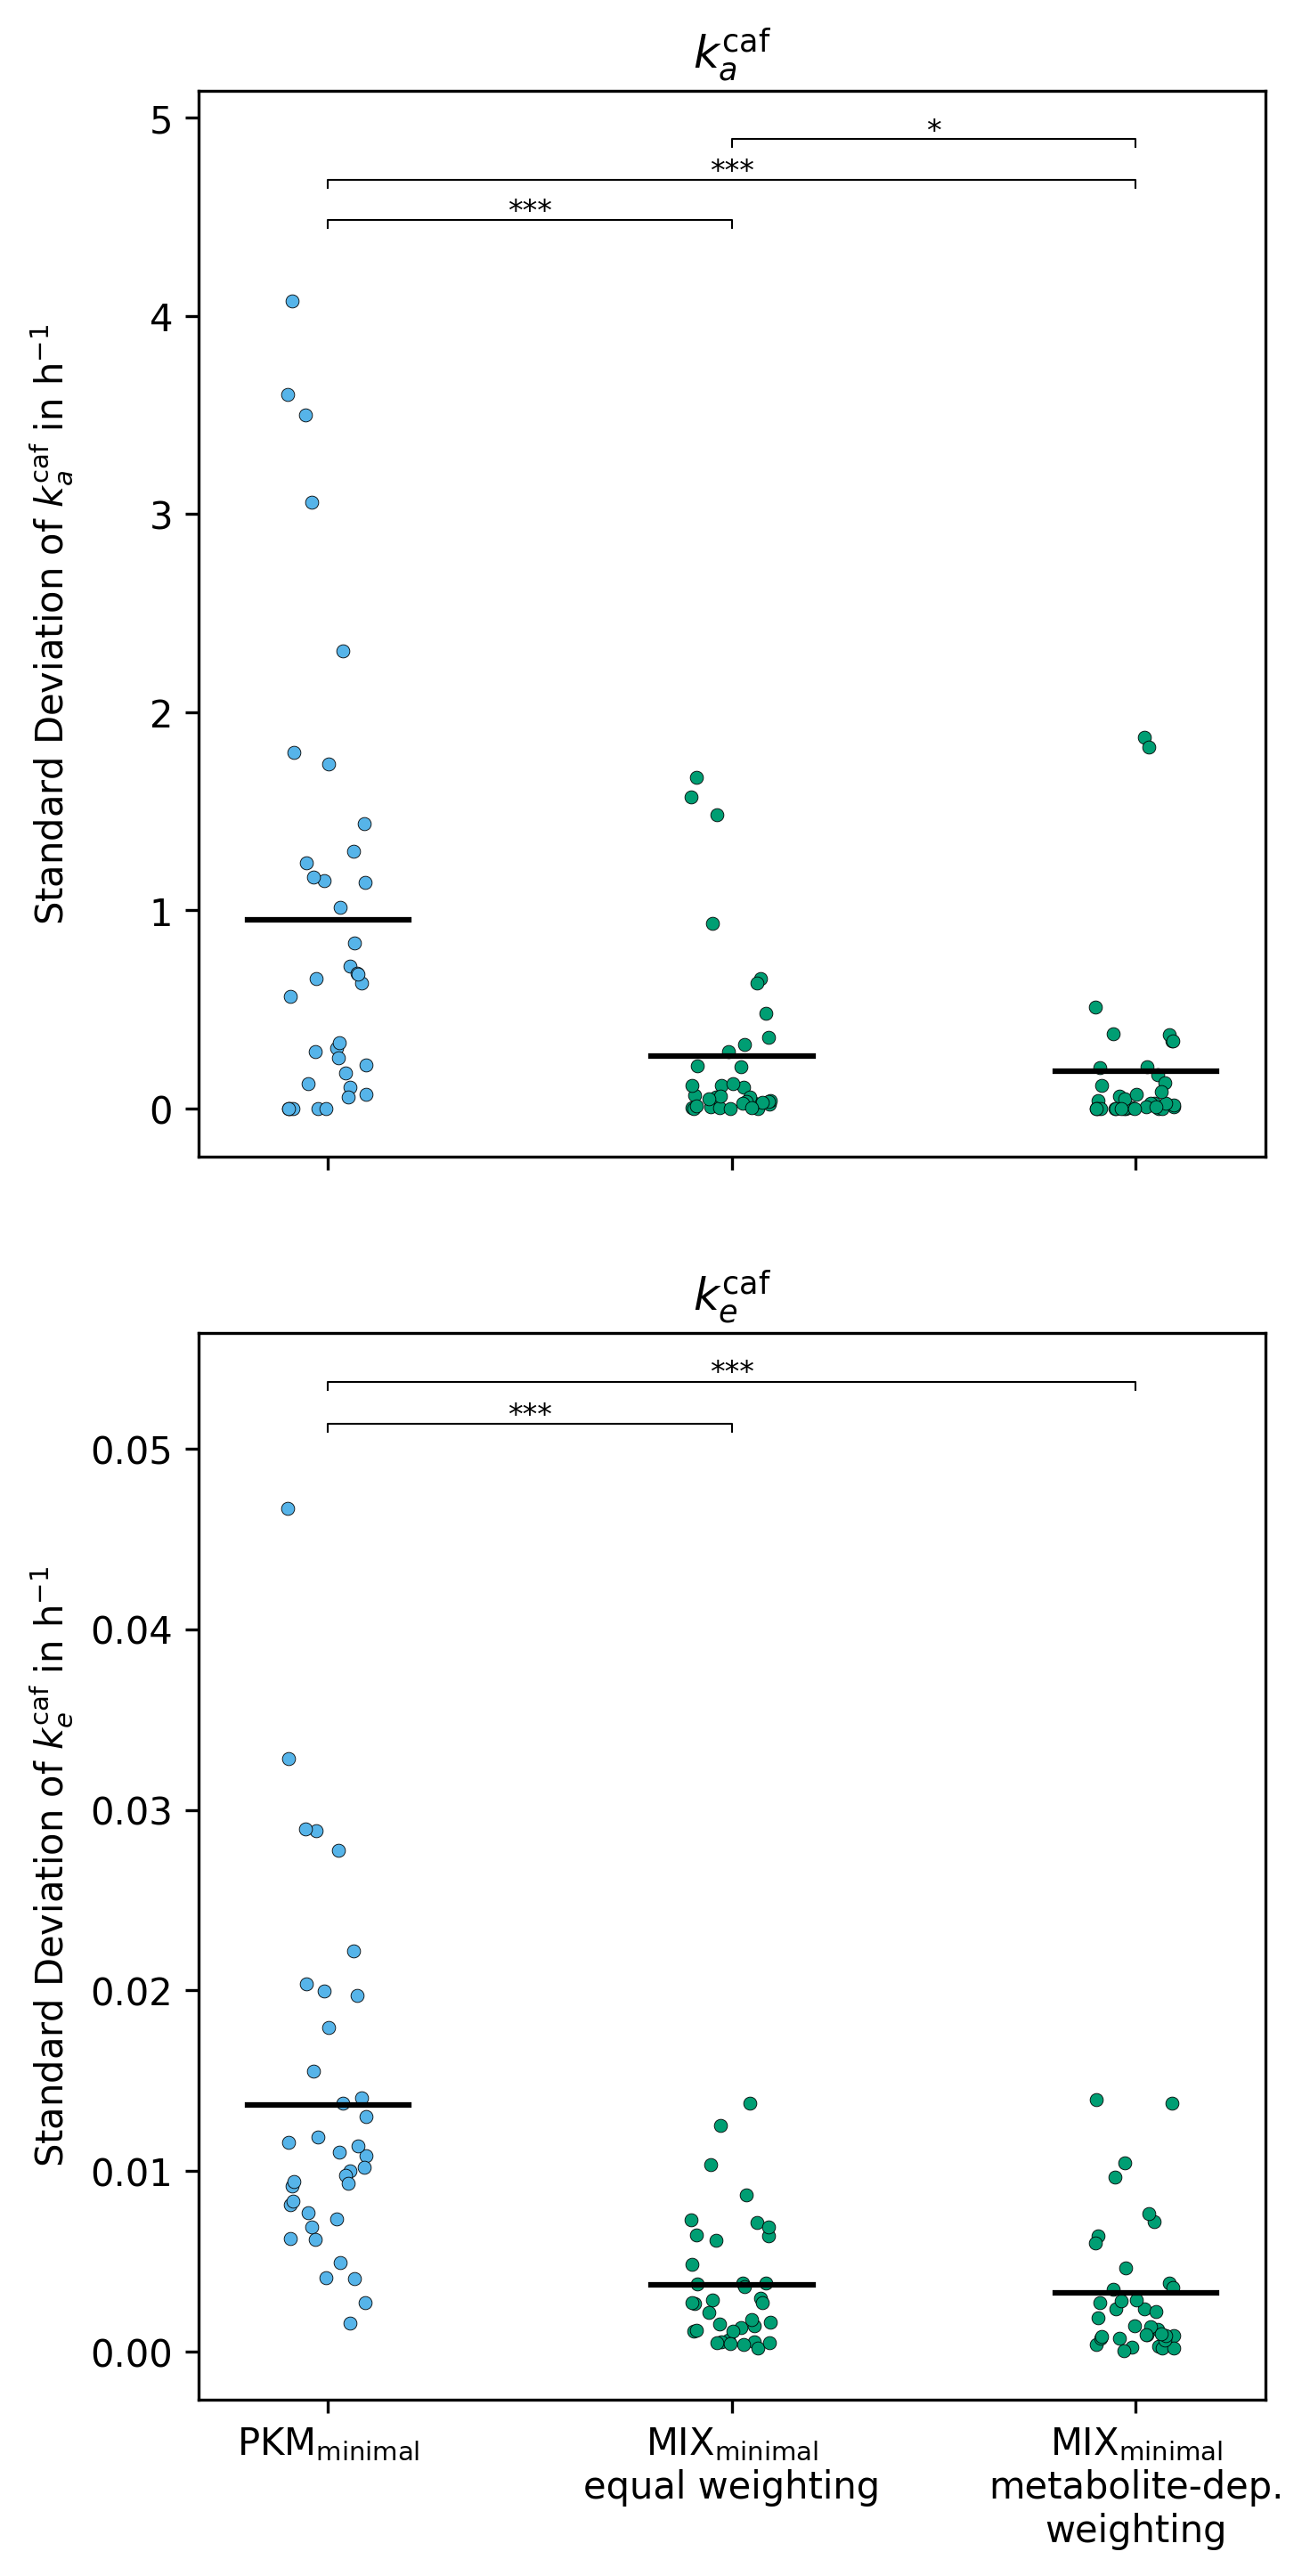

In [18]:
width = .1

path_list  = ['EM_sub_2','MIX_sub_2_n_EM','MIX_sub_2_n_PQN']
label_list = [r'PKM$_{\rm minimal}$',r'MIX$_{\rm minimal}$'+'\nequal weighting',r'MIX$_{\rm minimal}$'+'\nmetabolite-dep.\nweighting']
colors  = ['#56B4E9','#009E73','#009E73']
titles = [r'$k_a^{\rmcaf}$',r'$k_e^{\rmcaf}$']

# parse data
s_list = []
for path in path_list:
    print(path)
    s_list.append(get_stds(path))

# generate random numbers to make the datapoints more spread out
np.random.seed(13)
rand = np.random.uniform(-width,width,s_list[0].shape[0])

# start figure
fig = plt.figure(dpi=300,figsize=(5,10))

# subplot 1: ka
plt.subplot(211,box_aspect=1)
plt.ylabel(r'Standard Deviation of $k_a^{\rmcaf}$ in h$^{-1}$',labelpad=20)
plt.title(titles[0])
tmp_dic = {}
tmp_loc = {}
for nr in range(len(path_list)):
    tmp_s = s_list[nr]
    plt.scatter(np.ones(tmp_s.shape[0])*nr+rand,tmp_s[:,0], marker='.',s=50,edgecolor='k',linewidth=.2,color=colors[nr])
    plt.plot([nr-.2,nr+.2], [np.mean(tmp_s[:,0]), np.mean(tmp_s[:,0])],color='k')
    tmp_dic[path_list[nr]] = tmp_s[:,0]
    tmp_loc[path_list[nr]] = nr

calculate_significances(tmp_dic,tmp_loc)
plt.xticks(range(len(path_list)),[])
fig.tight_layout()

# subplot 2: ke
plt.subplot(212,box_aspect=1)
plt.title(titles[1])
plt.ylabel(r'Standard Deviation of $k_e^{\rmcaf}$ in h$^{-1}$')
tmp_dic = {}
tmp_loc = {}
for nr in range(len(path_list)):
    tmp_s = s_list[nr]
    plt.scatter(np.ones(tmp_s.shape[0])*nr+rand,tmp_s[:,1], marker='.',s=50,edgecolor='k',linewidth=.2,color=colors[nr])
    plt.plot([nr-.2,nr+.2], [np.mean(tmp_s[:,1]), np.mean(tmp_s[:,1])],color='k')
    tmp_dic[path_list[nr]] = tmp_s[:,1]
    tmp_loc[path_list[nr]] = nr
calculate_significances(tmp_dic,tmp_loc)
plt.xticks(range(len(path_list)),label_list)
fig.tight_layout()

# wrap up
plt.tight_layout()
plt.show()

## Figure 7

In [19]:
def get_deviations(path):
    best_parameters = parse_results(path)
    abs_devs = []
    rel_devs = []
    for donor in donors:
        k = []
        for metabolite in metabolites:
            tmp = best_parameters[donor][metabolite]
            ka = tmp[0]
            ke = tmp[1]+tmp[2]
            k.append([ka,ke])
        k = np.array(k)
        means = np.mean(k,axis=0)
        rel_devs.append((k-means[None,:])/means[None,:])
        abs_devs.append((k-means[None,:]))
    rel_devs = np.array(rel_devs)
    abs_devs = np.array(abs_devs)
    return rel_devs,abs_devs

def circle(r):
    x = np.linspace(-r,r,1000)
    return np.concatenate([x,-x]),np.concatenate([np.sqrt(r**2-x**2),-np.sqrt(r**2-x**2)])

METHOD           std(rel_ka) std(rel_ke)
EM_sub_2         0.32        0.42
MIX_sub_2_n_PQN  0.08        0.19


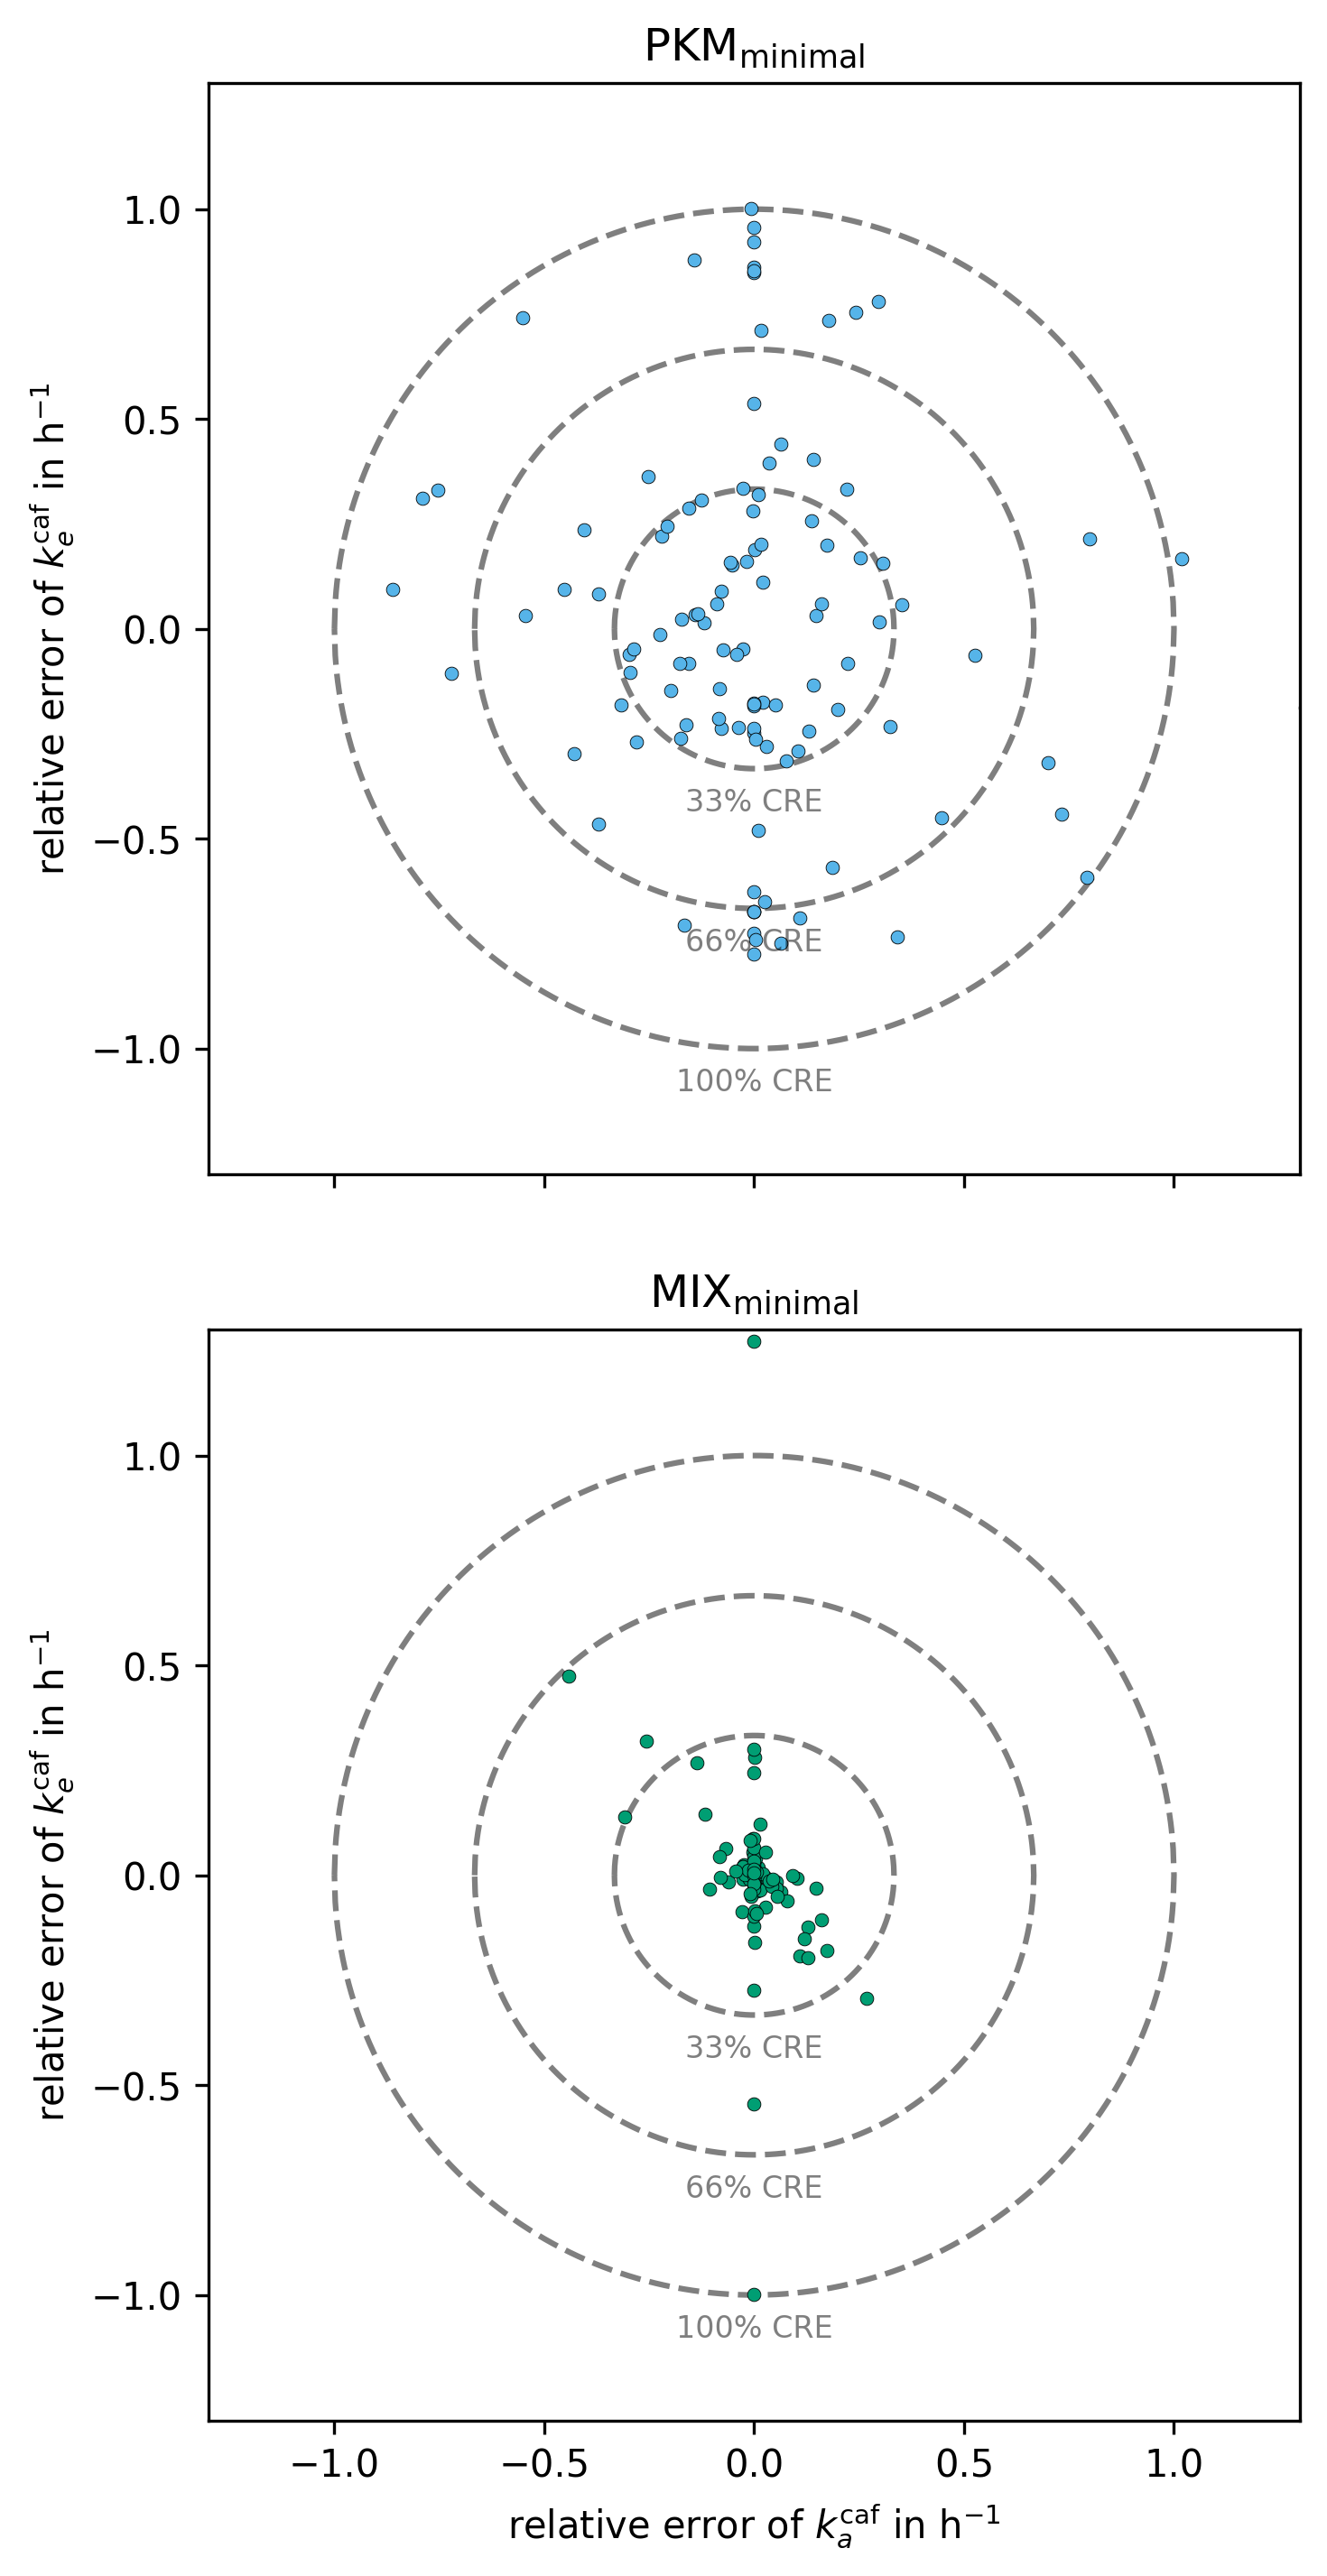

In [20]:
path_list  = ['EM_sub_2','MIX_sub_2_n_PQN']
label_list = [r'PKM$_{\rm minimal}$',r'MIX$_{\rm minimal}$']
colors  = ['#56B4E9','#009E73','#009E73']

fig = plt.figure(dpi=300,figsize=(5,10))
nr = 0
print('METHOD           std(rel_ka) std(rel_ke)')
for path in path_list:
    nr += 1
    ax = plt.subplot(2,1,nr,box_aspect=1)
    rel_devs,abs_devs = get_deviations(path)
    plt.scatter(rel_devs[:,:,0].flatten(),rel_devs[:,:,1].flatten(),marker='.',s=50,edgecolor='k',linewidth=.2,color=colors[nr-1])
    print('{:15} {:5.2f}       {:5.2f}'.format(path,np.std(rel_devs[:,:,0].flatten()),np.std(rel_devs[:,:,1].flatten())))
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    if nr == 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel(r'relative error of $k_a^{\rmcaf}$ in h$^{-1}$')
    ax.set_ylabel(r'relative error of $k_e^{\rmcaf}$ in h$^{-1}$')
    fig.tight_layout()
    
    plt.title(label_list[nr-1])
    # circles
    offset = .08
    tmpx, tmpy = circle(.333)
    plt.plot(tmpx,tmpy,'k--',zorder=0,alpha=.5)
    plt.text(0,-.333-offset,'33% CRE',ha='center',va='center',size=8,alpha=.5)
    tmpx, tmpy = circle(.666)
    plt.plot(tmpx,tmpy,'k--',zorder=0,alpha=.5)
    plt.text(0,-.666-offset,'66% CRE',ha='center',va='center',size=8,alpha=.5)
    tmpx, tmpy = circle(1)
    plt.plot(tmpx,tmpy,'k--',zorder=0,alpha=.5)
    plt.text(0,-1-offset,'100% CRE',ha='center',va='center',size=8,alpha=.5)

plt.tight_layout()
plt.show()

# Graphical Abstract

In [21]:
# load data
error_sigma   = .2
n_metabolites = 60
path          = 'v3'
base          = 'synthetic_data/simulation_results'
with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
    results_time,results_sv,results_model,raw_values = pickle.load(file)
    
methods = ['PQN','EM_full','EM_mini','MIX_full','MIX_mini']
c_true  = np.array(raw_values['C'])
v_true  = np.array(results_sv['TRUE'])
m_tilde = np.array(raw_values['M'])

In [22]:
measures = {}
for method in methods:
    print(method)
    tmp_v = np.array(results_sv[method])
    rel_ = []
    abs_ = []
    for bla_true,bla_pred in zip(v_true,tmp_v):
        bla_true_rel = bla_true/bla_true[0]
        bla_pred_rel = bla_pred/bla_pred[0]
        rel_.append((bla_true_rel-bla_pred_rel))
        abs_.append((bla_true-bla_pred))
    measures[method] = [rel_,abs_]

PQN
EM_full
EM_mini
MIX_full
MIX_mini


In [23]:
def plot_target(center):
    tmpx, tmpy = circle(.5)
    plt.plot(tmpx+center[0],tmpy+center[1],'--',zorder=0,alpha=1,color='grey')
    tmpx, tmpy = circle(.25)
    plt.plot(tmpx+center[0],tmpy+center[1],'--',zorder=0,alpha=1,color='grey')
    plt.plot([center[0],center[0]],[center[1]-.5,center[1]+.5],color='grey',zorder=0)
    plt.plot([center[0]-.5,center[0]+.5],[center[1],center[1]],color='grey',zorder=0)

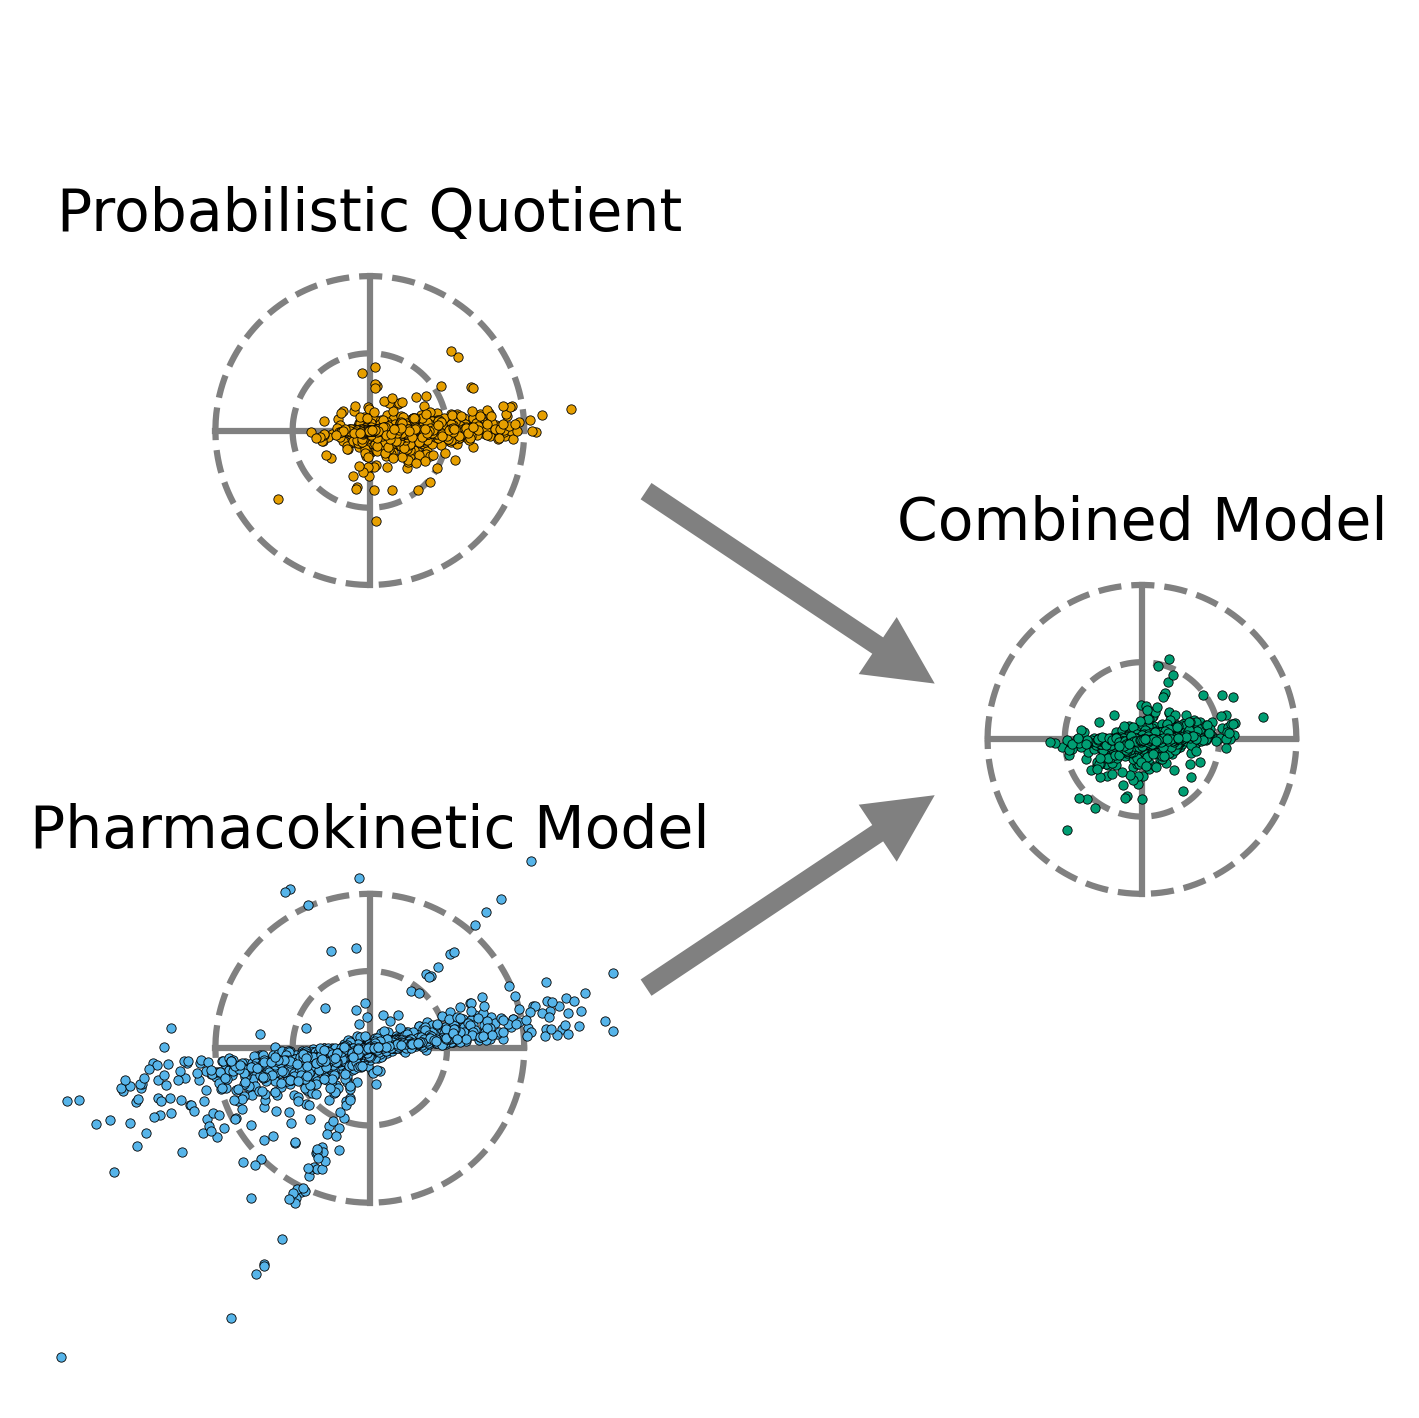

In [24]:
colors  = ['#E69F00','#56B4E9','#009E73','#009E73']
tmp_x, tmp_y = measures['EM_mini']
x_max = np.max(np.abs(tmp_x))
y_max = np.max(np.abs(tmp_y))
offset = .1

plt.figure(dpi=300,figsize=(6,6))
plt.subplot(111,box_aspect=1)

# pqn
center = (-1,1)
tmp_x, tmp_y = measures['PQN']
tmp_x = tmp_x/x_max
tmp_y = tmp_y/y_max
plt.scatter(np.array(tmp_y)+center[0], np.array(tmp_x)+center[1],color=colors[0],marker='.',s=20,edgecolor='k',linewidth=.2)
plot_target(center)

# em_mini
center = (-1,-1)
tmp_x, tmp_y = measures['EM_mini']
tmp_x = tmp_x/x_max
tmp_y = tmp_y/y_max
plt.scatter(np.array(tmp_y)+center[0], np.array(tmp_x)+center[1],color=colors[1],marker='.',s=20,edgecolor='k',linewidth=.2)
plot_target(center)


# mix_mini
center = (1.5,0)
tmp_x, tmp_y = measures['MIX_mini']
tmp_x = tmp_x/x_max
tmp_y = tmp_y/y_max
plt.scatter(np.array(tmp_y)+center[0], np.array(tmp_x)+center[1],color=colors[2],marker='.',s=20,edgecolor='k',linewidth=.2)
plot_target(center)

plt.axis('off')
plt.ylim(-2.1,2.3)
plt.xlim(-2.1,2.3)

plt.arrow(-.1,.8,1.5*.5,-1*.5,head_width=.2,head_length=.2,width=.05,fc='grey',ec='grey')
plt.arrow(-.1,-.8,1.5*.5,1*.5,head_width=.2,head_length=.2,width=.05,fc='grey',ec='grey')

# plt.text(-1,1.7,'PQN',ha='center',size=14)
# plt.text(-1,-.1,'PKM',ha='center',size=14)
# plt.text(1.5,.6,'MIX',ha='center',size=14)

plt.text(-1,1.65,'Probabilistic Quotient',ha='center',size=14)
plt.text(-1,-.35,'Pharmacokinetic Model',ha='center',size=14)
plt.text(1.5,.65,'Combined Model',ha='center',size=14)
plt.show()

# Pairwise Plots

In [25]:
def plot_pairwise_performance(diagnosis_name,results_sv,with_pqn=True,set_max=False):
    diagnosis_func = diagnosis[diagnosis_name]
    maximum = 0
    # list of all goodness of fit estimates
    tmp_pqn      = []
    tmp_em_full  = []
    tmp_mix_full = []
    tmp_em_mini  = []
    tmp_mix_mini = []
    # read out how many replicates there are in the dataset
    n_replicates = len(results_sv['PQN'])
    # loop over all replicates
    for n_replicate in range(n_replicates):
        sv_vector  = results_sv['TRUE'][n_replicate]
        # loop over all normalization methods
        for method, tmp_list in zip(['PQN','EM_full','EM_mini','MIX_full','MIX_mini'],[tmp_pqn,tmp_em_full,tmp_em_mini,tmp_mix_full,tmp_mix_mini]):
            tmp_sv = results_sv[method][n_replicate]
            tmp_diagnosis = diagnosis_func(sv_vector,tmp_sv)
            tmp_list.append(tmp_diagnosis)
        
    # plot the diagnosis parameters
    rand = np.random.uniform(-.1,.1,n_replicates)
    nr = 0
    rfcs = []
    for method, tmp_list in zip(['EM_mini','EM_full','MIX_mini','MIX_full','PQN'],[tmp_em_mini,tmp_em_full,tmp_mix_mini,tmp_mix_full,tmp_pqn]):
        if method == 'PQN' and with_pqn==False:
            pass
        else:
            # relative fold change
            rfc = np.array(tmp_list)/np.array(tmp_em_mini)*100
            rfcs.append(rfc)
            # mean relative fold change
            mrfc = np.mean(rfc)
            plt.scatter(np.ones(n_replicates)*nr+rand,rfc,color=colors[nr],marker='.',s=20,edgecolor='k',linewidth=.2)
            plt.plot([nr-.2,nr+.2],[mrfc,mrfc],color='k')
            print('{:10} mean = {:5.3f} std = {:5.3f}'.format(method,mrfc,np.std(rfc)))
        nr += 1
        

    # significances
    if method == 'PQN' and with_pqn==False:
        tmp_dic = {'EM_mini':tmp_em_mini,'EM_full':tmp_em_full,'MIX_mini':tmp_mix_mini,'MIX_full':tmp_mix_full}
    else:
        tmp_dic = {'EM_mini':tmp_em_mini,'EM_full':tmp_em_full,'MIX_mini':tmp_mix_mini,'MIX_full':tmp_mix_full,'PQN':tmp_pqn}
    tmp_loc = {'PQN':4,'EM_mini':0,'EM_full':1,'MIX_mini':2,'MIX_full':3}
    if np.max(rfcs) > maximum:
        maximum = np.max(rfcs)
    if set_max == False:
        pass
    else:
        maximum = set_max
    height          = maximum*1.1
    bracket_size    = .01
    text_offset     = .01
    height_increase = .05*maximum
    print('------- P VALUES ------')
    p_df = pd.DataFrame(columns=tmp_loc.keys(),index=tmp_loc.keys(),dtype=np.float64)
    for i,j in combinations(tmp_dic.keys(),2):
#         test_result = ss.mannwhitneyu(tmp_dic[i],tmp_dic[j])
        test_result = ss.wilcoxon(tmp_dic[i],tmp_dic[j])
        print('{:15} {:15} {:8.2e} {}'.format(i,j,test_result.pvalue,significance_star(test_result.pvalue)))
        p_df.loc[i,j] = test_result.pvalue
        if test_result.pvalue <= .05:
            if i == 'PQN' and with_pqn == False:
                pass
            else:
                plt.plot(np.array([tmp_loc[i],tmp_loc[i],tmp_loc[j],tmp_loc[j]]),
                         [height-maximum*bracket_size,height,height,height-maximum*bracket_size],
                         'k',
                         linewidth=.5
                        )
                plt.text(np.mean([tmp_loc[i],tmp_loc[j]]),
                         height+maximum*text_offset,
                         significance_star(test_result.pvalue),
                         ha='center',
                         va='center',
                         fontsize=8
                        )
                height += height_increase
    return nr, p_df

## Figuer S 10

EM_mini    mean = 100.000 std = 0.000
EM_full    mean = 42.686 std = 29.832
MIX_mini   mean = 34.930 std = 25.751
MIX_full   mean = 35.908 std = 23.585
------- P VALUES ------
EM_mini         EM_full         1.96e-17 ***
EM_mini         MIX_mini        6.31e-18 ***
EM_mini         MIX_full        4.81e-18 ***
EM_full         MIX_mini        9.66e-05 ***
EM_full         MIX_full        2.26e-03 **
MIX_mini        MIX_full        5.68e-02 -
EM_mini    mean = 100.000 std = 0.000
EM_full    mean = 64.296 std = 42.265
MIX_mini   mean = 29.870 std = 16.648
MIX_full   mean = 43.645 std = 31.065
------- P VALUES ------
EM_mini         EM_full         1.68e-13 ***
EM_mini         MIX_mini        3.90e-18 ***
EM_mini         MIX_full        3.33e-17 ***
EM_full         MIX_mini        4.02e-13 ***
EM_full         MIX_full        3.97e-11 ***
MIX_mini        MIX_full        5.17e-07 ***
EM_mini    mean = 100.000 std = 0.000
EM_full    mean = 88.603 std = 75.127
MIX_mini   mean = 40.678 std = 24.1

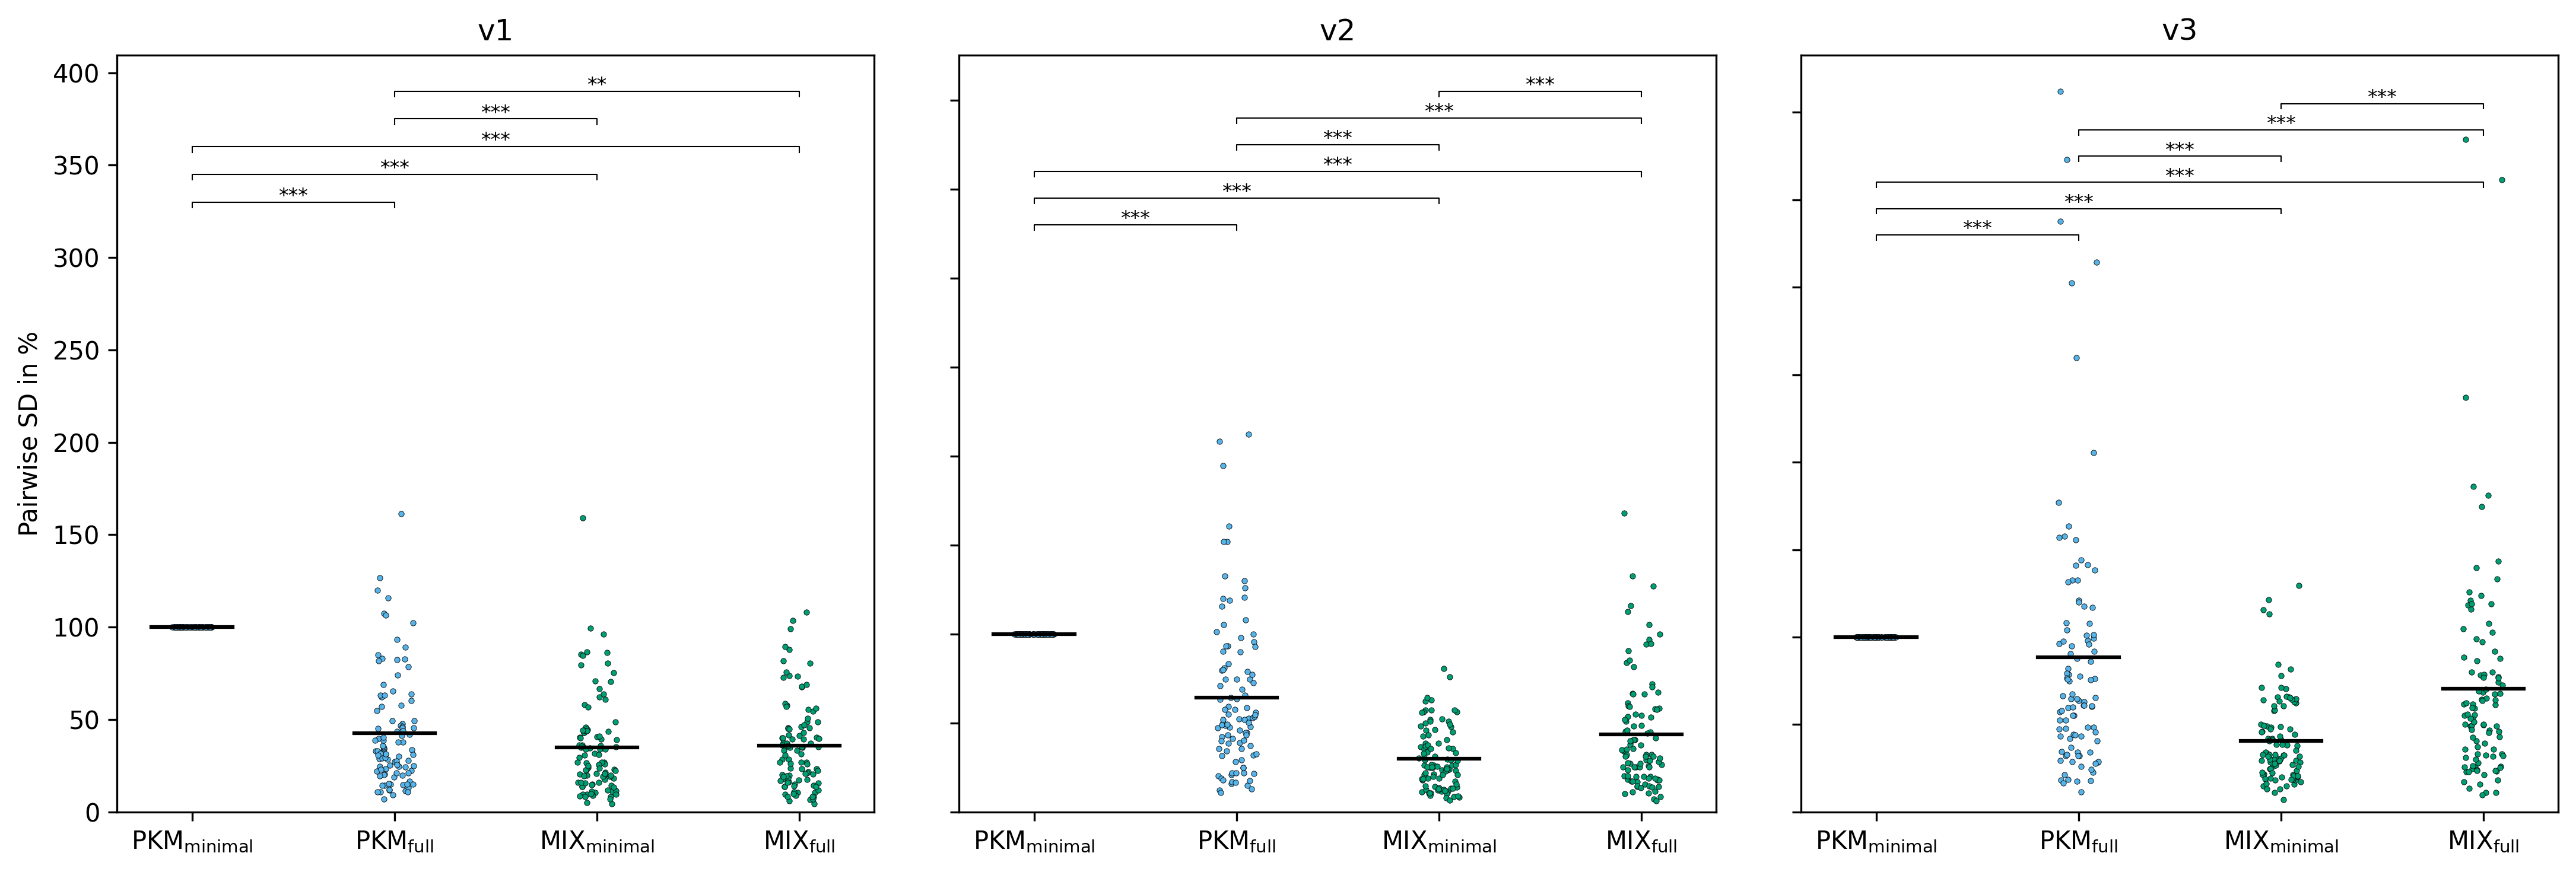

In [26]:
# load data
plt.figure(dpi=300,figsize=(15,5))
n_plot = 0
for path in ['v1','v2','v3']:
    n_plot += 1
    error_sigma   = .2
    n_metabolites = 60
    base          = 'synthetic_data/simulation_results'
    colors  = ['#56B4E9','#56B4E9','#009E73','#009E73','#E69F00']
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)

    labels  = [r'PKM$_{\rmminimal}$',r'PKM$_{\rmfull}$',r'MIX$_{\rmminimal}$',r'MIX$_{\rmfull}$']

    # plot figure
    ax = plt.subplot(1,3,n_plot,box_aspect=1)

    diagnosis_name = 'SD'
    nr,p_df = plot_pairwise_performance(diagnosis_name,results_sv,set_max=300,with_pqn=False)
    # save a csv with the p values
    p_df.T.to_csv(f'p_values_{diagnosis_name}_{path}.csv')
    if n_plot > 1:
        ax.set_yticklabels([])
    else:
        plt.ylabel(f'Pairwise {diagnosis_name} in %')
    plt.plot(0,0,color='b',label='PQN')
    plt.plot(0,0,color='r',label='EM')
    plt.plot(0,0,color='y',label='MIX')
    plt.xticks(range(0,nr-1),labels)
    plt.tight_layout()
    y_min,y_max = ax.get_ylim()
    x_min,x_max = ax.get_xlim()
    ax.set_title(path)
    ax.set_ylim(0,y_max)
plt.show()

## Figure S11

EM_mini    mean = 100.000 std = 0.000
EM_full    mean = 35.149 std = 17.529
MIX_mini   mean = 22.470 std = 11.708
MIX_full   mean = 22.449 std = 11.699
PQN        mean = 22.502 std = 11.726
------- P VALUES ------
EM_mini         EM_full         3.90e-18 ***
EM_mini         MIX_mini        3.90e-18 ***
EM_mini         MIX_full        3.90e-18 ***
EM_mini         PQN             3.90e-18 ***
EM_full         MIX_mini        2.41e-17 ***
EM_full         MIX_full        2.41e-17 ***
EM_full         PQN             2.41e-17 ***
MIX_mini        MIX_full        3.89e-16 ***
MIX_mini        PQN             3.77e-12 ***
MIX_full        PQN             2.76e-16 ***
EM_mini    mean = 100.000 std = 0.000
EM_full    mean = 55.365 std = 33.259
MIX_mini   mean = 22.698 std = 10.504
MIX_full   mean = 22.681 std = 10.519
PQN        mean = 22.732 std = 10.523
------- P VALUES ------
EM_mini         EM_full         3.78e-16 ***
EM_mini         MIX_mini        3.90e-18 ***
EM_mini         MIX_full        

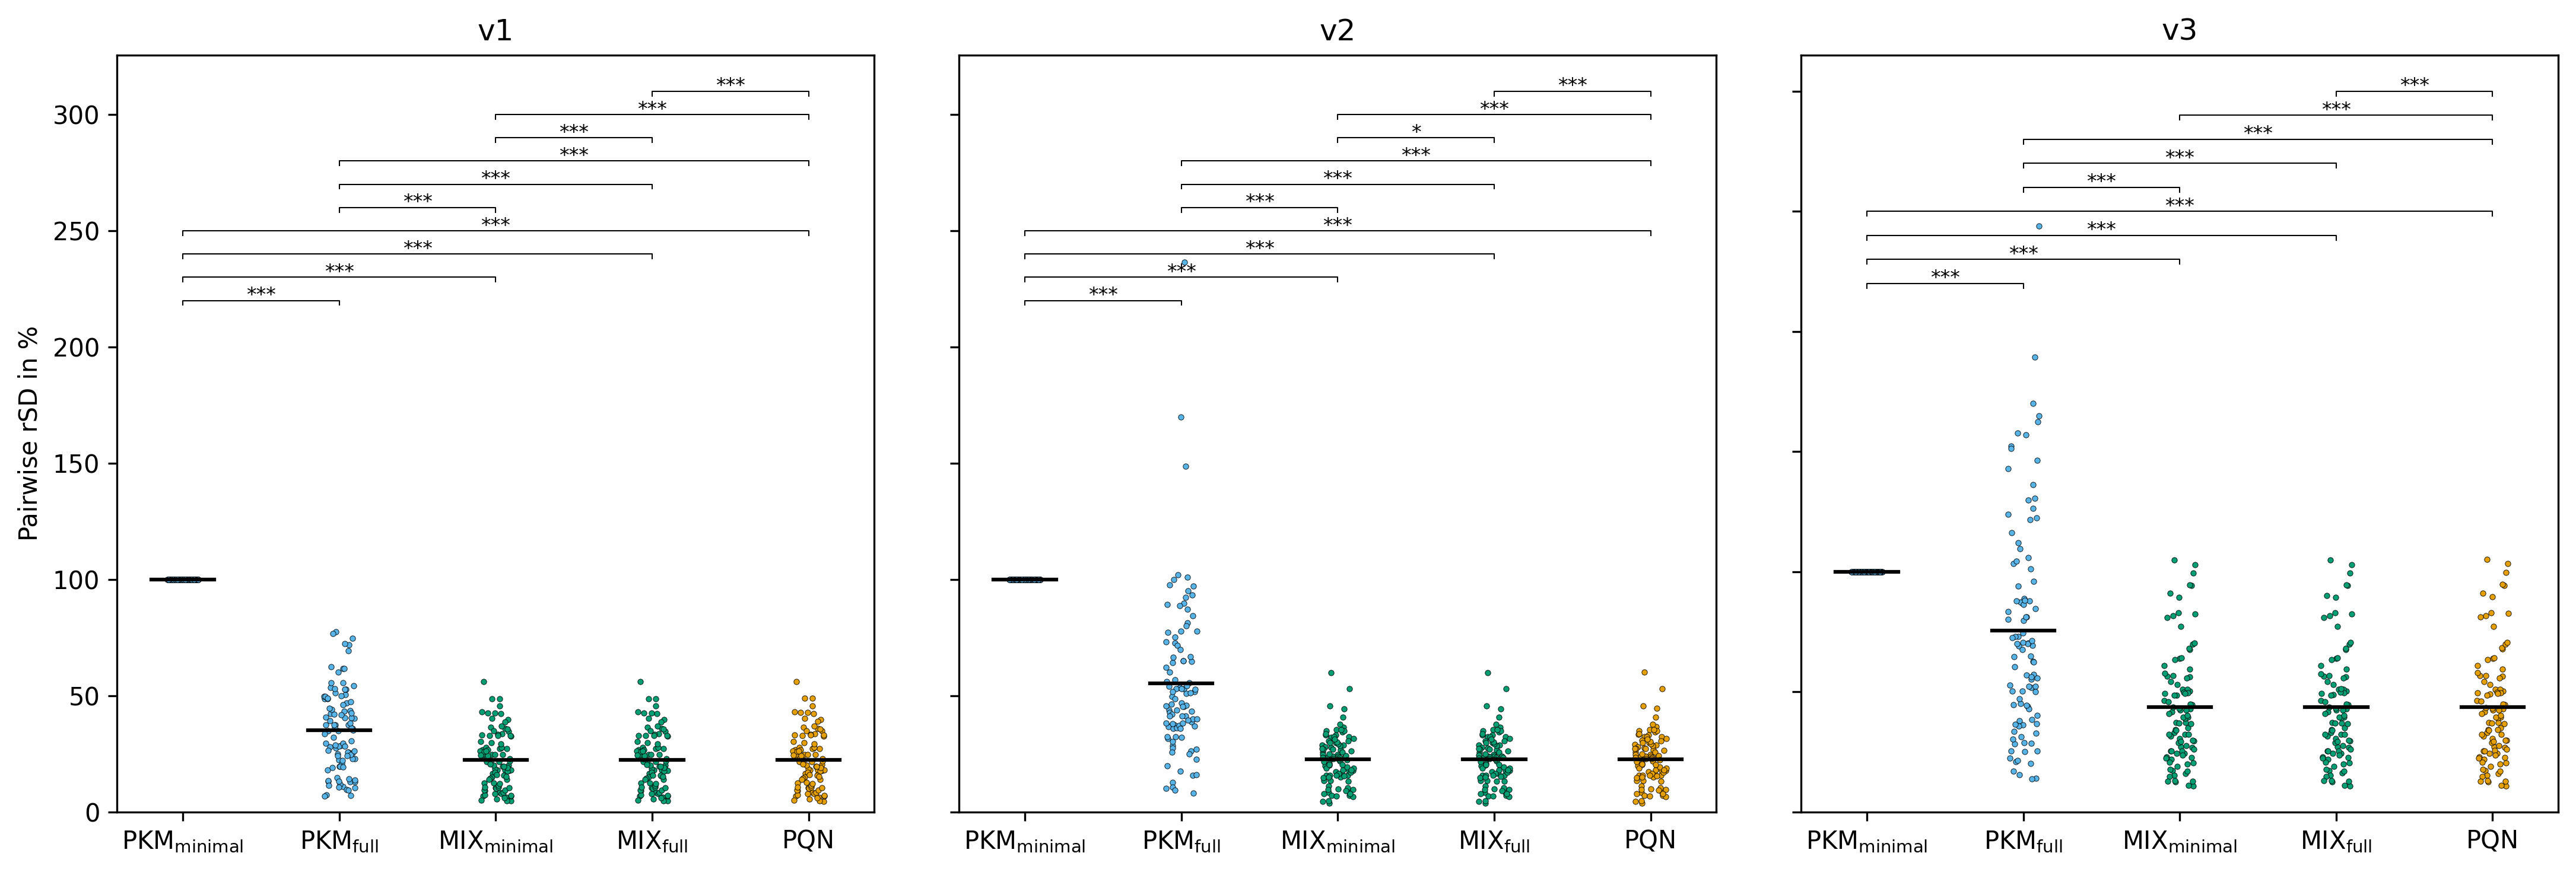

In [27]:
# load data
plt.figure(dpi=300,figsize=(15,5))
n_plot = 0
for path in ['v1','v2','v3']:
    n_plot += 1
    error_sigma   = .2
    n_metabolites = 60
#     path          = 'v3'
    base          = 'synthetic_data/simulation_results'
    colors  = ['#56B4E9','#56B4E9','#009E73','#009E73','#E69F00']
    with open(f'{base}/{path}_e_{error_sigma}_n_{n_metabolites}.pkl','rb') as file:
        results_time,results_sv,results_model,raw_values = pickle.load(file)

    labels  = [r'PKM$_{\rmminimal}$',r'PKM$_{\rmfull}$',r'MIX$_{\rmminimal}$',r'MIX$_{\rmfull}$','PQN']

    # plot figure
    ax = plt.subplot(1,3,n_plot,box_aspect=1)

    diagnosis_name = 'rSD'
    nr,p_df = plot_pairwise_performance(diagnosis_name,results_sv,set_max=200)
    # save a csv with the p values
    p_df.T.to_csv(f'p_values_{diagnosis_name}_{path}.csv')
    if n_plot > 1:
        ax.set_yticklabels([])
    else:
        plt.ylabel(f'Pairwise {diagnosis_name} in %')
    plt.plot(0,0,color='b',label='PQN')
    plt.plot(0,0,color='r',label='EM')
    plt.plot(0,0,color='y',label='MIX')
    plt.xticks(range(0,nr),labels)
    plt.tight_layout()
    y_min,y_max = ax.get_ylim()
    x_min,x_max = ax.get_xlim()
    ax.set_title(path)
    ax.set_ylim(0,y_max)
plt.show()